Name: Kyle Salgado-Gouker <br>
Date: November 14, 2023 <br>
Class: DSC540 - Professor Williams <br>
Project Milestone 5

## Final Project

#### This project can be built from the original pieces by enabling the following flags.

Otherwise it will load from the work-in-progress files from earlier milestones that are stored on Github.

There is also a flag that skips the downloads from Queue-Times.

In [1]:
# set to True to force downloads (This will take a long, long time - 4+ hours)
# set to None to use already downloaded files (or sql database)
DO_QT_DOWNLOAD = False

# start from files stored on GitHub.
# set to None to start from beginning
# set to True to start from stored sql
START_FROM_LAST_MILESTONE = True

#### Uncomment for Anaconda update.

In [2]:
# !conda update --all -y

#### Uncomment to install some packages.

In [3]:
# # Update pip
# !pip install --upgrade pip

# # Install required packages
# !pip install pandas numpy beautifulsoup4 matplotlib fuzzywuzzy tabulate

# !pip install scipy
# !pip install markdown
# !pip install werkzeug
# !pip install h5py
# !pip install wrapt


#### Packages for project.

In [4]:
import time

# file system searches etc
import os
from os.path import basename, exists
import glob

# regular expressions
import re
import math
# for sampling (will be required)
import random

# data frames
import pandas as pd
# smart arrays etc (will be required)
import numpy as np

# web access and html parsing (urllib, its submodules)
import requests
import urllib
import urllib.request
import urllib.error
from urllib.request import urlretrieve
# for a workaround.
import ssl

# work around read_html deprecation issue
from io import StringIO

import json

# parser of web pages
from bs4 import BeautifulSoup
# more efficient parsing.
import lxml

# for plots (will be required)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Fuzzy string matching
# If necessary, here are the installation commands.
# !pip install SciPy
# !pip install python-Levenshtein
# !pip install fuzzywuzzy
from fuzzywuzzy import fuzz

# for accessing sql (will be required)
import sqlite3

# fancy table printing
from tabulate import tabulate

In [5]:
# For testing: Make warnings fatal.

import warnings
warnings.filterwarnings("error")

In [6]:
# Store final project data in its own directory.

FINAL_DATA_DIRECTORY = "data/final"
QT_DATA_DIRECTORY = "data/final/QT"

# Check if the directory exists
if not os.path.exists(FINAL_DATA_DIRECTORY):
    # If it doesn't exist, make it
    os.makedirs(FINAL_DATA_DIRECTORY)
    print(f"Directory '{FINAL_DATA_DIRECTORY}' created.")

    # Check if the directory exists
if not os.path.exists(QT_DATA_DIRECTORY):
    # If it doesn't exist, make it
    os.makedirs(QT_DATA_DIRECTORY)
    print(f"Directory '{QT_DATA_DIRECTORY}' created.")


Directory 'data/final' created.
Directory 'data/final/QT' created.


In [7]:
# constants for accessing files and the web scraping urls.
WIKIPEDIA_PARK_RANKINGS = "https://en.wikipedia.org/wiki/List_of_amusement_park_rankings"
WIKIPEDIA_PARK_RANKINGS_FILE = FINAL_DATA_DIRECTORY+"/amusement_park_rankings.html"
RCDB_CSV_FILE = FINAL_DATA_DIRECTORY+"/coaster_db.csv"
RCSB_URL = "https://github.com/RobMulla/twitch-stream-projects/blob/main/001-rollercoaster-dataset/dbv1.csv"


In [8]:
# This SQL file has the tables from the previous milestones and some late enhancements.
# Using the SQL table is a short cut.
# Turn on START_FROM_LAST_MILESTONE (set to True)
# Set to False to regenerate from scratch.

SQL_WORK_IN_PROGRESS_FILE = FINAL_DATA_DIRECTORY + '/park_info.db'
SQL_WORK_IN_PROGRESS_URL = "https://github.com/kvsgouker/540FinalProject/blob/main/park_info.db"


#### Endpoints for APIs

In [9]:
# constants for accessing files and the web.
QUEUE_TIMES_API = "https://queue-times.com/en-US/pages/api"
QUEUE_TIMES_PARK_LIST_URL = "https://queue-times.com/en-US/parks?group=country"

In [10]:
QUEUE_TIMES_API = "https://queue-times.com/parks.json"

def getQueueTimesParkInformation():
    response = requests.get(QUEUE_TIMES_API)
    if response.status_code == 200:
        character_data = response.json()
        return character_data
    else:
        return "Error Occurred accessing QT"

In [11]:
GEOCODING_ACCESS_TOKEN = "pk.4484e1afc06c92181748c92cf6a5282f"
GEOCODING_URL = "https://us1.locationiq.com/v1/reverse?"

def getGeocodeInformation(latitude, longitude):
    params = {
        'key': GEOCODING_ACCESS_TOKEN,
        'lat': latitude,
        'lon': longitude,
        'normalize_address': '1',
        'format': 'json'
    }
    response = requests.get(GEOCODING_URL, params=params)
    # print("status code: ", response.status_code)
    if response.status_code == 200:
        character_data = response.json()
        return character_data
    elif response.status_code == 429:
        # Extract the Retry-After header value
        # This is to avoid hammering sites.
        retry_after = response.headers.get("Retry-After")
        if retry_after:
            # Convert the Retry-After value to seconds
            retry_after_seconds = int(retry_after)
            print("Rate limit exceeded. Waiting for " + str(retry_after_seconds) + " seconds.")
            time.sleep(retry_after_seconds)
        else:
            time.sleep(2)
        return(getGeocodeInformation(latitude, longitude))
    else:
        return "Error Occurred accessing Geocode"

def print_json(json_to_print):
    print(json.dumps(json_to_print, indent=4))


In [12]:
# web download function

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36"
}

# download: A good citizen download function
#     url - the url accessed
#     destination - local file to write
#
# respects code 429 and waits instead of pounding.

# Function to disable SSL certificate verification
def disable_ssl_verification():
    ssl._create_default_https_context = ssl._create_unverified_context

# Call the function to disable SSL verification
# This is to workaround an SSL certificate error I am getting.
disable_ssl_verification()

def download(url, destination, secure=True):
    try:
        # Send a GET request with headers
        response = requests.get(url, headers=headers, verify=secure)
        # Check if the request was successful
        if response.status_code == 200:
            with open(destination, 'w') as f:
                f.write(response.text)
            print("Downloaded " + destination)
        elif response.status_code == 429:
            # Extract the Retry-After header value
            # This is to avoid hammering sites.
            retry_after = response.headers.get("Retry-After")
            if retry_after:
                # Convert the Retry-After value to seconds
                retry_after_seconds = int(retry_after)
                print("Rate limit exceeded. Waiting for " + str(retry_after_seconds) + " seconds.")
                time.sleep(retry_after_seconds)
                # Retry the request after waiting
                download(url, destination)
            else:
                print("Rate limit exceeded. Retry-After header not found.")
        else:
            print("Website returned " + str(response.status_code))
    except urllib.error.HTTPError:
        print("Failed to download " + url)
    except Exception:
        print("Error writing " + destination)
    return

def downloadFile(url, filename):
    if not exists(filename):
        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local + "\n")
        return local, _

def downloadRawFile(url, filename):
    if not os.path.exists(filename):
        # Modify the URL to the raw content URL (replace "github.com" with "raw.githubusercontent.com")
        raw_url = url + "?raw=true"
        # Download the raw content
        local, _ = downloadFile(raw_url, filename)


### Useful functions.

* These are mostly for output.
* Mostly not using now. (will be required)

In [13]:
def pretty_print_df(df, rows=None):
    if rows is not None:
        df = df.head(rows)  # Use head() to limit the DataFrame to the specified number of rows
    # Use Tabulate to show the data.
    print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))
    print("\n" + "="*40 + "\n")  # Separation between DataFrames

# Prints a title decorated by stars.
def formatFancyTitle(title):
    # Calculate the length of the title
    title_length = len(title)
    # format title with decoration
    title = "*" * (title_length + 4) + "\n" + f"* {title} *" + "\n" + "*" * (title_length + 4) + "\n"
    return title

def formatTestStat(value, dec=6):
    format_string = "{:."+str(dec)+"f}"
    return format_string.format(value)

# white
TABLE_BACKGROUND_COLOR = (255, 255, 255)
# black
TABLE_FONT_COLOR = (0, 0, 0)
TABLE_FONT_SIZE = 12
TABLE_WIDTH = 600
TABLE_HEIGHT = 800
TYPEFACE_FILE = "/Library/Fonts/Menlo.ttc"

def drawText(image_filename, text, title = "", width=TABLE_WIDTH, height=TABLE_HEIGHT, background_color=TABLE_BACKGROUND_COLOR, font_name=TYPEFACE_FILE, font_color=TABLE_FONT_COLOR, font_size=TABLE_FONT_SIZE):
    # Create an image with white background
    image = Image.new('RGB', (width, height), background_color)
    # Set the font style and size
    font = ImageFont.truetype(font_name, font_size)
    # Create a drawing context
    draw = ImageDraw.Draw(image)
    # Calculate the position to start drawing the table
    x, y = 10, 10
    # Add an optional title.
    if len(title) > 0:
        text = formatFancyTitle(title) + "\n" + text
    # Draw the table onto the image
    draw.text((x, y), text, font=font, fill=font_color)
    # Save the image
    image.save(image_filename)
    return text
    
def drawTable(image_filename, table, title="", width=TABLE_WIDTH, height=TABLE_HEIGHT, background_color=TABLE_BACKGROUND_COLOR, font_name=TYPEFACE_FILE, font_color=TABLE_FONT_COLOR, font_size=TABLE_FONT_SIZE):
    text = drawText(image_filename, table, title, width, height, background_color, font_name, font_color, font_size)
    print(text)
    return text
    
def drawReport(image_filename, text, title="", width=TABLE_WIDTH, height=TABLE_HEIGHT, background_color=TABLE_BACKGROUND_COLOR, font_name=TYPEFACE_FILE, font_color=TABLE_FONT_COLOR, font_size=TABLE_FONT_SIZE):
    if len(title) > 0:
        drawText(image_filename, text, title, width, height, background_color, font_name, font_color, font_size)
        print(formatFancyTitle(title))
    else:
        drawText(image_filename, text)
    print(text)
    return text
    
# formats long tables side by side.    
def combineTables(table1, table2, table3):
    # Split the input strings into rows
    table1_rows = table1.strip().split("\n")
    table2_rows = table2.strip().split("\n")
    table3_rows = table3.strip().split("\n")
    
    max_row_count = max(len(table1_rows), len(table2_rows), len(table3_rows))
    combined_table = ""
    
    for row_idx in range(max_row_count):
        # Get the corresponding rows from each table
        table1_row = table1_rows[row_idx] if row_idx < len(table1_rows) else ""
        table2_row = table2_rows[row_idx] if row_idx < len(table2_rows) else ""
        table3_row = table3_rows[row_idx] if row_idx < len(table3_rows) else ""

        # Combine the rows into a single row
        combined_row = f"{table1_row} {table2_row} {table3_row}".strip()

        # Add the combined row to the overall table
        combined_table += combined_row + "\n"

    return combined_table



### Download the data files for this project (so far)

Download them locally. Two reasons:
* May not be accessible this weekend.
* Second file sometimes changes. (no surprises!)

In [14]:
if START_FROM_LAST_MILESTONE:
    # Get SQL Database with work in progress tables.
    downloadRawFile(SQL_WORK_IN_PROGRESS_URL, SQL_WORK_IN_PROGRESS_FILE)    
else:
    # Get wikipedia ranking page.
    downloadRawFile(WIKIPEDIA_PARK_RANKINGS, WIKIPEDIA_PARK_RANKINGS_FILE)
    # Get flat file.
    downloadRawFile(RCSB_URL, RCDB_CSV_FILE)

    # Workaround weird character conversion issue that started recently.
    encoding = "utf-8"
    # Read the HTML from the URL. Force "utf-8" encoding to workaround issue.
    with open(WIKIPEDIA_PARK_RANKINGS_FILE, 'r', encoding = encoding) as rankings_file:
        # Read the contents of the file into a buffer
        rankings_html = rankings_file.read()


Downloaded data/final/park_info.db



### Recently Flat File has new issues.

I can still use it but first I need to apply some fixes. 

#### Transformation 1: Drop the columns I don't need (or are useless) Flat File Transformation.

* Column 0: Ride Name  <<<=== File missing this column. Starts with a comma.
* Column 1 & 2: Drop
* Column 3: Park Name
* Column 4-5: Drop
* Column 6: Opening Date Keep
* Column 7-8: Drop
* Column 9: Manufacturer
* Column 10-11: Drop
* Column 12: Height
* Column 13: Length
* Column 14: Speed
* Column 15: Inversions
* Column 16: Duration keep
* Column 17: Capacity keep
* Column 18: Height Restriction
* Column 19-21: Drop
* Column 22: Cost Keep
* Column 23-end: Drop


#### First, fix the issue with the missing column header.

Note: This seems like a recent new problem, since the file I analyzed before did not exhibit the issue. 

#### Transformation 1: Fix the bad column header. Flat File Transformation.

In [15]:
if not START_FROM_LAST_MILESTONE:
    # Load the CSV file into a string buffer
    with open(RCDB_CSV_FILE, 'r') as file:
        csv_data = file.read()

    # If the file is missing the first column header, fix it.
    if csv_data.startswith(','):
        print("Fixing csv file: ", RCDB_CSV_FILE)
        csv_data = "Ride name" + csv_data
        # Save the modified CSV data.
        with open(RCDB_CSV_FILE, 'w') as file:
            file.write(csv_data)


#### Now the csv file can be used.

In [16]:
if not START_FROM_LAST_MILESTONE:
    # Read csv file into panda and make a data frame.

    columns_to_load = ["Ride name", "Location", "Opening date", "Type", "Manufacturer", "Height", "Length",
     "Speed", "Inversions", "Duration", "Capacity", "Height Restriction", "Cost", 
     "Drop", "Max vertical angle", "G-force"]

    # These columns will all need to be transformed into more useful types but for now I need to load them and the only choice is str.
    dtype_options = {
        "Ride name": str,
        "Location": str,
        "Opening date": str,
        "Type": str, 
        "Manufacturer": str,
        "Height": str,
        "Length": str,
        "Speed": str,
        "Inversions": str,
        "Duration": str,
        "Capacity": str,
        "Height Restriction": str,
        "Cost": str, 
        "Drop": str,
        "Max vertical angle": str,
        "G-force": str
    }

    rcdb_df = pd.read_csv(RCDB_CSV_FILE, usecols=columns_to_load, dtype=dtype_options)


#### Time to have a closer look at the flat file.


In [17]:
if not START_FROM_LAST_MILESTONE:
    desired_columns = ['Ride name', 'Location']
    sorted_df = rcdb_df.sort_values(by='Ride name')

    print(tabulate(sorted_df[desired_columns], headers='keys', tablefmt='pretty', showindex=False))


#### Transformation 2: Fix the first column's data. Flat File Transformation.

* Remove the records with nan in Location or Ride name.
* Remove the records with garbage Ride names (the ones in parentheses), which will not match Queue Time rides.

In [18]:
def parse_ride_name_and_location(row):
    # define a pattern to fix the bad data:
        # ^: Match beginning of string.
        # \(: Only edits fields that start with '('
        # (?:"(.*?)"|\'(.*?)\') - Matches all the text between double quote or single quotes
        # \s* Skips space.
        # , skips comma (only 'outside' the quoted strings)
        # \s* Skips space.
        # (?:"(.*?)"|\'(.*?)\') - Again, matches all the text between double quote or single quotes
        # \): Matches a closing parenthesis.
        # $: End of the string.
        
    pattern = r'^\((?:"(.*?)"|\'(.*?)\')\s*,\s*(?:"(.*?)"|\'(.*?)\')\)$'

    # Check if the data in 'Ride name' matches the above pattern.
    match = re.match(pattern, row['Ride name'])
    
    if match:
        # Fix the data of the two columns when it matches
        if match.group(1):
            row['Ride name'] = match.group(1) # first double quote (.*?)
        else:
            row['Ride name'] = match.group(2) # first single quote (.*?)
        
        if match.group(3):
            row['Location'] = match.group(3) # second double quote (.*?)
        else:
            row['Location'] = match.group(4) # second single quote (.*?)
    
    return row

if not START_FROM_LAST_MILESTONE:
    # Perform this transformation on the data set.
    # axis = 1 means apply the function to every row.
    rcdb_df = rcdb_df.apply(parse_ride_name_and_location, axis=1)


#### Review fixed data.

In [19]:
if not START_FROM_LAST_MILESTONE:
    sorted_df = rcdb_df.sort_values(by='Ride name')
    print(tabulate(sorted_df[desired_columns], headers='keys', tablefmt='pretty', showindex=False))


#### Transformation 3: Delete obvious trash. Flat File Transformation.

* Remove the records with nan in Location or Ride name.


In [20]:
if not START_FROM_LAST_MILESTONE:
    print(len(rcdb_df), " original records.")

    # Drop records where 'Location' or 'Ride name' is NaN or an empty string
    rcdb_df.dropna(subset=['Location', 'Ride name'], inplace=True)
    rcdb_df = rcdb_df[rcdb_df['Location'] != '']  # Remove empty strings in 'Location'
    rcdb_df = rcdb_df[rcdb_df['Ride name'] != '']  # Remove empty strings in 'Ride name'

    print(len(rcdb_df), " records after discarding trash.")


#### Transformation 4: Drop duplicates. Flat File Transformation.

For now I will define duplicates as same Ride name, same Location. Ride names are sometimes repeated in other parks.

In [21]:
if not START_FROM_LAST_MILESTONE:
    # Define 'duplicate' as when Ride name and Location are the same.
    rcdb_df.drop_duplicates(subset=['Ride name', 'Location'], inplace=True)

    print(len(rcdb_df), " records after dropping duplicates.")


- ok, now there are no duplicates, but there have been. Still counts as a transformation!

### Transformation 5: Resolve Park Name Conflict (build a unique key across the 3 data bases, use QT Park Number)

#### The park name in the flat file must be the same as in the Queue Times file.

First, though, I need a universal park name between the other two data sources.

### Process Wikipedia Rankings.

The most important data here are the park names and the year-by-year attendance figures.

In [22]:
if not START_FROM_LAST_MILESTONE:
    # Parse wikipedia rankings using Beautiful Soup with the lxml parser
    soup = BeautifulSoup(rankings_html, 'lxml')

    # Get the tables
    tables = soup.find_all('table')

    # Store DataFrames for each table in a list.
    dataframes = []

    # Skip table 0 - Corporations
    # Skip table 1 - Worldwide
    # Skip tables 6+ - Waterparks (for now)

    wiki_columns = ['Rank', 'Amusement park', 'Location', '2009', '2010', '2011', '2012', 
                    '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

    # Use these 4 tables (most popular parks in North America, Latin America, Asia, and Europe/Middle East)
    for table in tables[2:5]:
        # Make a data frame from each table.
        html_str = str(table)
        # Workaround deprecation issuee.
        html_io = StringIO(html_str)
        # Read the HTML from the StringIO object
        df = pd.read_html(html_io)[0]

        df.columns = wiki_columns
        # Each html page scraped is a different beast.
        # This solves the issue with the wikipedia page parsing.
        # Sometimes I need the text of the td item, but sometimes the name of the park is iin a title attribute
        if 'Amusement Park' in df.columns:
            df['Amusement Park'] = df['Amusement Park'].apply(lambda x: x['title'] if isinstance(x, dict) and 'title' in x else x)
        # Add dataframe to a list.
        dataframes.append(df)

    # Concatenate the DataFrames into one DataFrame.
    all_wiki_amusement_parks_df = pd.concat(dataframes, ignore_index=True)

    # Drop the 'Rank' column. Do this before finding duplicates!
    all_wiki_amusement_parks_df.drop(columns=['Rank'], inplace=True)

    # Remove duplicate rows based on all columns
    all_wiki_amusement_parks_df.drop_duplicates(inplace=True)

    # Convert all columns except 'Amusement Park' and 'Location' to numbers. Needed for stats and plotting later.
    columns_to_convert = all_wiki_amusement_parks_df.columns.difference(['Amusement park', 'Location'])
    all_wiki_amusement_parks_df[columns_to_convert] = all_wiki_amusement_parks_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

    # Replace NaN values with 0 in the combined DataFrame. Attendance = 0 when park is closed for pandemic, never opened, or gone for good.
    # List of columns to fill with 0
    columns_to_fillna_with_0 = ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

    # Loop through each column and fill NaN with 0
    for column in columns_to_fillna_with_0:
        all_wiki_amusement_parks_df[column].fillna(0, inplace=True)

    # Sort the data frame by Amusement park.
    all_wiki_amusement_parks_df = all_wiki_amusement_parks_df.sort_values(by='Amusement park')

    # Fix the column names.
    wiki_columns = ['Amusement park', 'Location', '2009', '2010', '2011', '2012', 
                    '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']

    all_wiki_amusement_parks_df.columns = wiki_columns

### Let's see the full list of amusement parks!

In [23]:
if not START_FROM_LAST_MILESTONE:
    wiki_desired_columns = ['Amusement park', 'Location', '2009', '2021']
    print(tabulate(all_wiki_amusement_parks_df[wiki_desired_columns], headers='keys', tablefmt='pretty', showindex=False))


### Introduce 2 Fields for Park Matching.

* Park number: Matching Park number in Queue Times data, which will be the unique Park identifier.
* Best match: For Fuzzy string matching.

In [24]:
if not START_FROM_LAST_MILESTONE:
    all_wiki_amusement_parks_df['Park number'] = ""
    all_wiki_amusement_parks_df['Best match'] = ""


#### Web Scrape Queue Times for Park Numbers.

In [25]:
if not START_FROM_LAST_MILESTONE:
    # URL to web scrape.
    url = QUEUE_TIMES_PARK_LIST_URL

    # Read it.
    response = requests.get(url)

    # If the request was successful
    if response.status_code == 200:

        soup = BeautifulSoup(response.text, 'html.parser')

        # Initialize lists to store the data
        amusement_parks = []
        park_numbers = []
        countries = []

        # Each web page is a little different.
        # The QT park page by country has a separate panel for each country.
        # Inside each country panel is the park a_tag which has the data (see below)
        #
        # 1. Find all the <div> panels (countries)
        div_panels = soup.find_all('div', class_='panel')

        # Iterate through the countries
        for panel in div_panels:
            # Find the <h2> tag inside the panel
            country_name = panel.find('h2').text.strip()

            # Find all the <a> Park tags inside the panel
            a_tags = panel.find_all('a', class_='panel-block')

            # Iterate through the Park <a> tags
            for a_tag in a_tags:
                # Extract the Amusement park and link
                amusement_park = a_tag.text.strip()
                link = a_tag['href'] 
                amusement_park = amusement_park.split("\n")[0]
                # Append the data to the lists
                amusement_parks.append(amusement_park)
                # The park number is part of the link.
                park_numbers.append(link.split("/")[-1])
                countries.append(country_name)

        # Make the dataframe from the lists collected in the scrapiing.
        QT_park_list_df = pd.DataFrame({
            'Amusement park': amusement_parks,
            'Park number': park_numbers,
            'Country': countries
        })

        # ALL DONE!

        # Display the DataFrame
        print(tabulate(QT_park_list_df, headers='keys', tablefmt='pretty', showindex=False))
    else:
        print("Failed to fetch the URL from Queue Times.")

### Match Amusement Parks by name and move Park Number field from QT DF into Wiki DF.

* Exact match
* Near match (QT inside Wiki)
* Near match (Wiki inside QT)
* Fuzzy match.


#### Note: The fuzzy matching algorithm cannot resolve a few important differences between some wikipedia/queuetime entries.

Fix these now. They will be then be skipped in the Park Matching algorithm.

In [26]:
if not START_FROM_LAST_MILESTONE:
    # These parks need to be set.
    all_wiki_amusement_parks_df.loc[all_wiki_amusement_parks_df['Amusement park'] == 'Disneyland Park', 'Park number'] = '16'
    all_wiki_amusement_parks_df.loc[all_wiki_amusement_parks_df['Amusement park'] == 'Disneyland Hong Kong', 'Park number'] = '31'
    all_wiki_amusement_parks_df.loc[all_wiki_amusement_parks_df['Amusement park'] == 'Disneyland Park at Disneyland Paris', 'Park number'] = '4'
    all_wiki_amusement_parks_df.loc[all_wiki_amusement_parks_df['Amusement park'] == 'Magic Kingdom Theme Park at Walt Disney World Resort', 'Park number'] = '6'
    all_wiki_amusement_parks_df.loc[all_wiki_amusement_parks_df['Amusement park'] == 'Walt Disney Studios Park at Disneyland Paris', 'Park number'] = '28'
    
    # # These parks need to be removed because Queue Times doesn't include them.
    indices_to_remove = [index for index, row in all_wiki_amusement_parks_df.iterrows() if row['Amusement park'] in 
                         ['Fantasilandia', 'La Feria', 'Parque Mundo Aventura', 'Parque Plaza Sésamo', 'Parque Warner', 
                          'Parque Xcaret', 'Parque de la Costa', 'Theme Parque Nacional del Café', 'Puy du Fou',
                          'Mundo Petapa', 'Futuroscope', 'La Feria Chapultepec Mágico', 'Tivoli Gardens',
                          'Fun Spot America']]

    # Remove rows with the specified indices
    all_wiki_amusement_parks_df.drop(indices_to_remove, inplace=True)



### Park matching algorithm.

In [27]:
if not START_FROM_LAST_MILESTONE:
    for w, row_wiki in all_wiki_amusement_parks_df.iterrows():
        amusement_park_w = row_wiki['Amusement park']

        # Initialize variables to store the best match and its index
        best_match_index = None
        best_match_score = -1

        # Iterate through each row in QT_park_list_df
        for q, row_QT in QT_park_list_df.iterrows():
            amusement_park_Q = row_QT['Amusement park']

            # exact match first
            if row_wiki['Park number'] == "" and amusement_park_w == amusement_park_Q:
                # print(f"Exact match for {amusement_park_w} and {amusement_park_Q}")
                all_wiki_amusement_parks_df.at[w, 'Park number'] = row_QT['Park number']
                break

            # if queue time string is in wiki string
            elif row_wiki['Park number'] == "" and amusement_park_w.find(amusement_park_Q) != -1:
                # print(f"Near match (wiki contains QT) for {amusement_park_w} and {amusement_park_Q}")
                all_wiki_amusement_parks_df.at[w, 'Park number'] = row_QT['Park number']
                break

            # if wiki string is in queue time string
            elif row_wiki['Park number'] == "" and amusement_park_Q.find(amusement_park_w) != -1:
                # print(f"Near match (QT contains wiki) for {amusement_park_w} and {amusement_park_Q}")
                all_wiki_amusement_parks_df.at[w, 'Park number'] = row_QT['Park number']
                break

            # fuzzy match
            elif row_wiki['Park number'] == "":
                fuzz_score = fuzz.ratio(amusement_park_w, amusement_park_Q)
                # print(f"Fuzzy match for {amusement_park_w} and {amusement_park_Q}: {fuzz_score}")

                if fuzz_score > best_match_score:
                    best_match_score = fuzz_score
                    best_match_index = q

        if all_wiki_amusement_parks_df.at[w, 'Park number'] == "" and best_match_index is not None:
            all_wiki_amusement_parks_df.at[w, 'Park number'] = QT_park_list_df.at[best_match_index, 'Park number']


In [28]:
if not START_FROM_LAST_MILESTONE:
    # Print the two data frames after matching.
    desired_columns = ['Amusement park', 'Park number']
    sorted_df = all_wiki_amusement_parks_df.sort_values(by='Amusement park')
    print(tabulate(sorted_df[desired_columns], headers='keys', tablefmt='pretty', showindex=False))
    desired_columns = ['Amusement park', 'Park number']
    sorted_df = QT_park_list_df.sort_values(by='Amusement park')
    print(tabulate(sorted_df[desired_columns], headers='keys', tablefmt='pretty', showindex=False))


### Now I have a uniform method of referencing parks.

- I need to apply it to the flat file.

#### Transformation 6: Use a uniform park reference. 

* Match Location of RCDB against Amusement park field of QT/Wiki. I use both!
* Create Ride Number field.

In [29]:
if not START_FROM_LAST_MILESTONE:
    # Introduce Park number field in flat file.
    rcdb_df['Park number'] = ""


### Park Matching/Resolution for RCDB

* Look for matches (same strategy as before) for RCDB Location in QT
* Look for matches (same strategy as before) for RCDB Location in Wiki.
* Fuzzy matching across BOTH.
* Introduce Park number variable in RCDB to be unique park identifier across all data sets.

#### After Matching

1. Park number positive = near match or exact match.
2. Park number negative = fuzzy match.

In [30]:
if not START_FROM_LAST_MILESTONE:
    for rcdb_index, row_rcdb in rcdb_df.iterrows():
        location = row_rcdb['Location']

        # Initialize variables to store the best match and its index
        best_park_number = None
        best_match_score = -1
        best_match_amusement_park = ""

        # Iterate through each row in QT_park_list_df
        for q, row_QT in QT_park_list_df.iterrows():
            amusement_park_Q = row_QT['Amusement park']
            park_number = row_QT['Park number']

            # exact match first
            if row_rcdb['Park number'] == "" and location == amusement_park_Q:
                # print(f"Q Exact match for {location} and {amusement_park_Q}  - park = {park_number}")
                rcdb_df.at[rcdb_index, 'Park number'] = row_QT['Park number']
                break

            # if queue time string is in wiki string
            elif row_rcdb['Park number'] == "" and location.find(amusement_park_Q) != -1:
                # print(f"Q Near match (location contains QT) for {location} and {amusement_park_Q}  - park = {park_number}")
                rcdb_df.at[rcdb_index, 'Park number'] = row_QT['Park number']
                break

            # if wiki string is in queue time string
            elif row_rcdb['Park number'] == "" and amusement_park_Q.find(location) != -1:
                # print(f"Q Near match (QT contains location) for {location} and {amusement_park_Q}  - park = {park_number}")
                rcdb_df.at[rcdb_index, 'Park number'] = row_QT['Park number']
                break

            # fuzzy match
            elif row_rcdb['Park number'] == "":
                fuzz_score = fuzz.ratio(location, amusement_park_Q)
                # print(f"Fuzzy match for {location} and {amusement_park_Q}: {fuzz_score}")

                if fuzz_score > best_match_score:
                    best_match_score = fuzz_score
                    best_park_number = row_QT['Park number']
                    best_match_amusement_park = amusement_park_Q

        for w, row_wiki in all_wiki_amusement_parks_df.iterrows():
            amusement_park_w = row_wiki['Amusement park']
            park_number = row_wiki['Park number']
            # exact match first
            if row_rcdb['Park number'] == "" and amusement_park_w == location:
                # print(f"W Exact match for {amusement_park_w} and {location} - park = {park_number}")
                rcdb_df.at[rcdb_index, 'Park number'] = row_wiki['Park number']
                break

            # if queue time string is in wiki string
            elif row_rcdb['Park number'] == "" and location.find(amusement_park_w) != -1:
                # print(f"W Near match (location contains amusement_park_w) for {amusement_park_w} and {location} - park = {park_number}")
                rcdb_df.at[rcdb_index, 'Park number'] = row_wiki['Park number']
                break

            # if wiki string is in queue time string
            elif row_rcdb['Park number'] == "" and amusement_park_w.find(location) != -1:
                # print(f"W Near match (amusement_park_w contains location) for {amusement_park_w} and {location} - park = {park_number}")
                rcdb_df.at[rcdb_index, 'Park number'] = row_wiki['Park number']
                break

            # fuzzy match
            elif row_rcdb['Park number'] == "":
                fuzz_score = fuzz.ratio(location, amusement_park_w)
                # print(f"Fuzzy match for {location} and {amusement_park_w}: {fuzz_score}")

                if fuzz_score > best_match_score:
                    best_match_score = fuzz_score
                    best_park_number = row_wiki['Park number']
                    best_match_amusement_park = amusement_park_w


        if rcdb_df.at[rcdb_index, 'Park number'] == "" and best_park_number is not None:
            rcdb_df.at[rcdb_index, 'Park number'] = "-"+best_park_number
            # print(f"Fuzzy match for {location} is {best_match_amusement_park}")


In [31]:
if not START_FROM_LAST_MILESTONE:

    desired_columns = ['Ride name', 'Location', 'Park number']
    sorted_df = rcdb_df.sort_values(by='Ride name')

    print(tabulate(sorted_df[desired_columns], headers='keys', tablefmt='pretty', showindex=False))


#### Fuzzy Matches That Worked

* Hagrid’s Magical Creatures Motorbike Adventure     |    Universal's Islands of Adventure     |     -64 
*  Insane                         |               Gröna Lund                |    -166  
*  Jetline                        |               Gröna Lund                |    -166  
*  Jurassic World VelociCoaster              |    Universal's Islands of Adventure     |     -64  
*  Kvasten                        |               Gröna Lund                |    -166
*  Monster                        |               Gröna Lund                |    -166 
*  Orkanen                        |            Fårup Sommarland             |     -18 
*  Steel Eel                       |          SeaWorld San Antonio           |     -22 
*  Texas Stingray                     |          SeaWorld San Antonio           |     -22 
*  The Great White                    |          SeaWorld San Antonio           |     -22 
*  The Incredible Hulk Coaster              |    Universal's Islands of Adventure     |     -64 
*  Tornado                        |     Parque de Atracciones de Madrid     |    -321   
*  Vilda Musen                      |               Gröna Lund                |    -166   

For these coasters change the Park number to positive by stripping the '-'.

In [32]:

if not START_FROM_LAST_MILESTONE:
    # Rides matching park (Fun Spot America) need to be removed. This is a bad fuzzy match.
    rcdb_df = rcdb_df[~rcdb_df['Location'].str.contains('Fun Spot America', case=False)]

    # Fuzzy matching worked for a few important coasters. I need to strip off the '-' of their Park number fields.
    resolved_fuzzy_parks = [-18, -22, -64, -166, -321]

    # Flip the sign of the parks that match the list above.
    rcdb_df['Park number'] = rcdb_df['Park number'].astype(str).str.strip().astype(int)
    rcdb_df.loc[rcdb_df['Park number'].isin(resolved_fuzzy_parks), 'Park number'] *= -1
    desired_columns = ['Ride name', 'Location', 'Park number']
    sorted_df = rcdb_df.sort_values(by='Ride name')

    print(tabulate(sorted_df[desired_columns], headers='keys', tablefmt='pretty', showindex=False))


### The Fuzzy Match sometimes worked! 

#### I fixed the coasters entries for those fuzzy parks.

### Transformation 7: Drop all rides that are not in the Queue Times Database

In [33]:
if not START_FROM_LAST_MILESTONE:
    # Drop records where 'Ride name' starts with '(' and ends with ')'
    rcdb_df = rcdb_df[~(rcdb_df['Park number']<0)]

    print(len(rcdb_df))

### Ride List (Intersection of QT/Wiki/Flat)

In [34]:
if not START_FROM_LAST_MILESTONE:
    desired_columns = ['Ride name', 'Location', 'Park number']
    sorted_df = rcdb_df.sort_values(by='Ride name')

    print("Master List of Rides (so far)")
    print(tabulate(sorted_df[desired_columns], headers='keys', tablefmt='pretty', showindex=False))


#### Review Column Names

* For Rides
* For Parks

<span style="color:red">
    <b><u>Transformation 8</u></b>: Change Park (from wikipedia) column names for consistency across sets.
</span>

In [35]:
if not START_FROM_LAST_MILESTONE:

    rcdb_df = rcdb_df.rename(columns={
        'Location': 'Park_Name',
        'Ride name': 'Ride_Name',
        'Max vertical angle': 'Max_Vertical_Angle',
        'Park number': 'Park_Number',
        'Opening date': 'Opening_Date',
        'Height Restriction': 'Height_Restriction'
    })


    all_wiki_amusement_parks_df = all_wiki_amusement_parks_df.rename(columns={'Amusement park': 'Park_Name',
                                                'Park number': 'Park_Number'})

    if 'Best match' in all_wiki_amusement_parks_df.columns:
        all_wiki_amusement_parks_df.drop(columns=['Best match'], inplace=True)


<span style="color:red">
    <b><u>Transformation 9</u></b>: Add attendance fields from 2006-2008 and 2022+ using Queue Times
</span>

Note: This has the same source as the Wikipedia page. The Wikipedia table does not include this data.

* TEA/ERA. 2008 Attraction Attendance Report. Themed Entertainment Association (TEA); 2009 https://www.teaconnect.org/images/files/TEA_23_503031_140617.pdf. Accessed 30 December, 2021.
* TEA/ERA. 2007 Attraction Attendance Report. Themed Entertainment Association (TEA); 2008 https://www.teaconnect.org/images/files/TEA_29_601512_140617.pdf. Accessed 30 December, 2021.
* TEA/ERA. 2006 Theme Park Attendance Report. Themed Entertainment Association (TEA); 2007 https://www.teaconnect.org/images/files/TEA_158_724007_160525.pdf. Accessed 30 December, 2021.
* TEA/AECOM. 2022 Theme Index and Museum Index: The Global Attractions Attendance Report. Themed Entertainment Association (TEA); 2023 https://aecom.com/wp-content/uploads/documents/reports/AECOM-Theme-Index-2022.pdf. Accessed 8 July, 2023.

In [36]:
if not START_FROM_LAST_MILESTONE:
    # List of columns to add
    columns_to_add = ['2006', '2007', '2008', '2022']

    # Initialize the new columns with NaN values
    for column in columns_to_add:
        all_wiki_amusement_parks_df = all_wiki_amusement_parks_df.assign(**{column: np.nan})

#### Web Scrape of Queue Times.

* Use Queue Times API to obtain Parks and Rides
* Webscrape the Queue Times Pages for Ride Entries in each park.
* Add missing rides to rides data base.
* Add missing parks to parks data base.
* Build transaction file of wait times using web scraping.

Webscraping - First grab all the necessary web documents from Queue_Times.

Use friendly download to avoid battering the server.

Start with QT_park_list_df, a simple data base read from the QT parks main page.

     Amusement park               | Park number |       Country   

Files are stored in QT_DATA_DIRECTORY:
    Optional attendance File has format: "attendance_"+park_number+".html"
    Overall stats file has format: "overall_stats_"+park_number+".html"
    Yearly stats files have this format: park_number+"_"+year+"_stats.html"

For each park_number in list:
	Download queue-times.com/parks/{park_number}/attendances
	Download queue-times.com/parks/{park_number}/stats
	stats_html = read_html
	use soup to find all tags with format <a href="/parks/{park_number}/stats/* 
	these indicate the years of statistics on the site
	for each matching year:
		Download queue-times.com/parks/{park_number}/stats/{year}


In [37]:
if DO_QT_DOWNLOAD and not START_FROM_LAST_MILESTONE:

    # Get all park numbers from queue time list.
    qt_parks = QT_park_list_df['Park number']

    # For each park.
    for qt_park in qt_parks:
        # park *may* have attendance data. If so, grab it.
        url_attendance = "https://queue-times.com/parks/" + str(qt_park) + "/attendances"
        attendance_filename = QT_DATA_DIRECTORY + "/attendance_" + str(qt_park) + ".html"

        # Download attendance data using requests library.
        response_attendance = requests.get(url_attendance)
        with open(attendance_filename, 'wb') as attendance_file:
            attendance_file.write(response_attendance.content)

        # All parks should have statistics.
        url_statistics = "https://queue-times.com/parks/" + str(qt_park) + "/stats"
        statistics_filename = QT_DATA_DIRECTORY + "/overall_stats_" + str(qt_park) + ".html"

        # Download statistics data using requests library.
        response_statistics = requests.get(url_statistics)
        with open(statistics_filename, 'wb') as statistics_file:
            statistics_file.write(response_statistics.content)

        try:
            # Read the HTML from the URL.
            with open(statistics_filename, 'r') as overall_stats_file:
                # Read the contents of the file into a buffer
                overall_stats_html = overall_stats_file.read()
                soup = BeautifulSoup(overall_stats_html, 'html.parser')

                # Find all tags with format <a href="/parks/{park_number}/stats/*
                for tag in soup.find_all('a', href=True):
                    if f"/parks/{qt_park}/stats/" in tag['href']:
                        year = tag['href'].split("/stats/")[1]
                        year_url = f'https://queue-times.com{tag["href"]}'
                        year_stats_filename = QT_DATA_DIRECTORY + f"/{str(qt_park)}_{year}_stats.html"

                        # Download year-specific statistics data.
                        response_year_stats = requests.get(year_url)
                        with open(year_stats_filename, 'wb') as year_stats_file:
                            year_stats_file.write(response_year_stats.content)
        except Exception as e:
            print(f"Error reading {statistics_filename}: {str(e)}")

In [38]:
if DO_QT_DOWNLOAD and not START_FROM_LAST_MILESTONE:

    # I should have downloaded the files into subfolders, but I'll move them around now.
    # First build the directory structure.
    # Create attendance, overall, and stats directories if they don't exist
    for subdir in ['attendance', 'overall', 'stats', 'rides', 'rides/overall']:
        dir_path = os.path.join(QT_DATA_DIRECTORY, subdir)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
            print(f"Directory '{dir_path}' created.")

    # Define the year range
    year_range = range(2014, 2024)  # From 2014-2023.

    # Create subdirectories for each year within the 'stats' directory
    for year in year_range:
        # make subfolder name for each year.
        dir_name = os.path.join(QT_DATA_DIRECTORY, 'stats', str(year))
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
            print(f"Directory '{dir_name}' created.")
        dir_name = os.path.join(QT_DATA_DIRECTORY, 'rides', str(year))
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
            print(f"Directory '{dir_name}' created.")
        

In [39]:
if DO_QT_DOWNLOAD and not START_FROM_LAST_MILESTONE:

    # Now move the downloaded files.
    # ParkNumber_YearNumber_stats.html -> data/final/QT/stats/YearNumber/ParkNumber.html
    # attendance_ParkNumber.html -> data/final/QT/attendance/ParkNumber.html
    # overall_stats_ParkNumber.html -> data/final/QT/overall/ParkNumber.html

    # Get all park numbers from the queue time list.
    qt_parks = QT_park_list_df['Park number']

    # For each park.
    for qt_park in qt_parks:
        # year stats files into each year subfolder of stats.
        for year in year_range:
            test_filename = os.path.join(QT_DATA_DIRECTORY, f"{qt_park}_{year}_stats.html")
            if os.path.isfile(test_filename):
                destination = os.path.join(QT_DATA_DIRECTORY, "stats", str(year), f"{qt_park}.html")
                os.rename(test_filename, destination)
        # attendance files into attendance subfolder
        attendance_filename = os.path.join(QT_DATA_DIRECTORY, f"attendance_{qt_park}.html")
        if os.path.isfile(attendance_filename):
            destination = os.path.join(QT_DATA_DIRECTORY, "attendance", f"{qt_park}.html")
            os.rename(attendance_filename, destination)
        # overall stats files into overall subfolder
        overall_stats_filename = os.path.join(QT_DATA_DIRECTORY, f"overall_stats_{qt_park}.html")
        if os.path.isfile(overall_stats_filename):
            destination = os.path.join(QT_DATA_DIRECTORY, "overall", f"{qt_park}.html")
            os.rename(overall_stats_filename, destination)


In [40]:
# # copy the data frames before (in case) I break them (FOR DEBUGGING)
# df_wiki_copy = all_wiki_amusement_parks_df.copy()

In [41]:
if not START_FROM_LAST_MILESTONE:
    all_wiki_amusement_parks_df = all_wiki_amusement_parks_df.copy() # (FOR DEBUGGING. TO AVOID RELOADING)

In [42]:
if not START_FROM_LAST_MILESTONE:
    # Define the list of columns to convert to integers
    string_columns = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', 
                       '2017', '2018', '2019', '2020', '2021', '2022']

    # Iterate through numeric columns and apply conversion
    for column in string_columns:
        all_wiki_amusement_parks_df[column] = all_wiki_amusement_parks_df[column].astype('str')


In [43]:
if not START_FROM_LAST_MILESTONE:
    selected_columns = all_wiki_amusement_parks_df.columns
    print(tabulate(all_wiki_amusement_parks_df[selected_columns].head(5), headers=selected_columns, tablefmt='pretty', showindex=False))

    print("QT Before Rename")
    selected_columns = QT_park_list_df.columns
    print(tabulate(QT_park_list_df[selected_columns].head(5), headers=selected_columns, tablefmt='pretty', showindex=False))


    # Define a dictionary to map the old column names to the new names
    column_mapping = {
        'Amusement park': 'Park_Name',
        'Park number': 'Park_Number',
        'Country': 'Location'
    }

    # Use the rename method to rename the columns
    QT_park_list_df = QT_park_list_df.rename(columns=column_mapping)

    # Now the columns should be renamed
    print("QT after Rename")
    selected_columns = QT_park_list_df.columns
    print(tabulate(QT_park_list_df[selected_columns].head(5), headers=selected_columns, tablefmt='pretty', showindex=False))

    # Define the desired column order
    desired_order = ["Park_Number", "Park_Name", "Location"] + [str(year) for year in range(2006, 2023)]

    # Reorder the columns
    all_wiki_amusement_parks_df = all_wiki_amusement_parks_df[desired_order]

    all_wiki_amusement_parks_df.to_csv(FINAL_DATA_DIRECTORY+'/original_web_parks.csv', index=False)


#### Load Attendance Data (if available) for all parks.

<span style="color:red">
    <b><u>Transformation 10</u></b>: Side effect of previous transformation - adds records that are candidates for data set.
</span>

This code loads the webscraped html tables and transfers the Queue-Timess 2006-2008 and 2022 data. 

In [44]:
def convert_park_data_types(df):
    # Convert all columns (except 'Park_Number') to string
    columns_to_string = df.columns.difference(['Park_Number'])
    df[columns_to_string] = df[columns_to_string].astype(str)
    # Convert 'Park_Number' to int
    df['Park_Number'] = df['Park_Number'].astype(int)
    return df


In [45]:
if not START_FROM_LAST_MILESTONE:
    all_wiki_amusement_parks_df = convert_park_data_types(all_wiki_amusement_parks_df)
    wiki_database_columns = ['Park_Number', 'Park_Name', 'Location', '2006', '2007', '2008', '2009', '2010', 
                            '2011', '2012', '2013', '2014', '2015', 
                            '2016', '2017', '2018', '2019', '2020', '2021', '2022']
    parks_df = pd.DataFrame(columns=wiki_database_columns)

    print(len(all_wiki_amusement_parks_df), " park records before processing attendance.")

    attendance_dir = os.path.join(QT_DATA_DIRECTORY, "attendance")

    for filename in os.listdir(attendance_dir):
        if filename.endswith(".html"):
            # Extract park_number from the filename
            park_number = filename.split(".")[0]

            qt_matching_record = QT_park_list_df[QT_park_list_df['Park_Number'] == park_number].iloc[0]

            print("Processing park ", park_number, ". Park name = ", qt_matching_record['Park_Name'])

            # Check if the record exists in the DataFrame

            matching_record_df = all_wiki_amusement_parks_df[all_wiki_amusement_parks_df['Park_Number'] == int(park_number)]

            if matching_record_df.empty:
                new_data = {'Park_Number': int(park_number),
                            'Park_Name': qt_matching_record['Park_Name'],
                            'Location': qt_matching_record['Location']}
                # set attendance data to nan if unknown.
                for year in range(2006, 2023):
                    new_data[str(year)] = np.nan

                print("Adding new record: Attendance Data for park ", park_number, ". Park name = ", qt_matching_record['Park_Name'])
                # initialize dataframe with new record.
                matching_record_df = pd.DataFrame([new_data])
                matching_record_df = convert_park_data_types(matching_record_df)

            # restrict to necessary coolumns
            matching_record_df = matching_record_df[wiki_database_columns]
            # get the 0th record of the frame (make it a series) - NOTE: There is only ever one.
            # Avoid slice by working on a copy.
            matching_record = matching_record_df.iloc[0].copy()

            # Read the downloaded file,
            with open(os.path.join(attendance_dir, filename), 'r', encoding='utf-8') as attendance_file:
                attendance_html = attendance_file.read()

            # Use soup to get the table.
            soup = BeautifulSoup(attendance_html, 'html.parser')
            attendance_table = soup.find('table', {'class': 'table is-fullwidth'})

            if attendance_table:
                # Use Pandas to read the HTML table into a DataFrame
                html_str = str(attendance_table)
                # Workaround deprecation issuee.
                html_io = StringIO(html_str)
                # Read the HTML from the StringIO object
                # Take the first DataFrame in the list:
                attendance_df = pd.read_html(html_io)[0]

                # Convert 'Year' and 'Attendance' columns to appropriate data types
                # The table entries have junk besides numbers in them.
                attendance_df['Year'] = attendance_df['Year'].astype(str).str.extract(r'(\d+)').astype(int)
                # The Attendance has a 'footnote' - I use a regular expression to grab the number.
                attendance_df['Attendance'] = attendance_df['Attendance'].astype(str).str.replace(',', '', regex=True).str.extract(r'(\d+)').astype(int)

                # use the park name and location from queue times as the 'correct' names
                # I already set park name in roller coaster data base to match the QT park name.
                matching_record['Park_Name'] = qt_matching_record['Park_Name']
                # Do not change Location. It is more descriptive than QT's, Country alone.

                # Set each year in matching_record to the Attendance in attendance_df
                for year in range(2006, 2023):
                    attendance_year_test_df = attendance_df[attendance_df['Year'] == year]
                    if not attendance_year_test_df.empty:
                        attendance_value = attendance_year_test_df['Attendance'].values[0]
                        matching_record[str(year)] = attendance_value
                        # print("Park: ", park_number, ". Name: ", qt_matching_record['Park_Name'],
                        #       ". Year: ", year, ". Attendance: ", attendance_value)

            # add new record
            parks_df = pd.concat([parks_df, pd.DataFrame([matching_record], columns=wiki_database_columns)], ignore_index=True)


    print(len(parks_df), " park records after processing attendance.")


#### The new dataframe, park_df, has 81 new possible candidates for inclusion.


Note: Most of these will be removed later, because of too many nan columns.

#### The code below shows the current state. Only selected columns are shown.

In [46]:
if not START_FROM_LAST_MILESTONE:
    selected_columns=['Park_Number', 'Park_Name', '2006', '2007', '2008', '2015', '2020', '2022']
    print(tabulate(parks_df[selected_columns].head(25), headers=selected_columns, tablefmt='pretty', showindex=False))

<span style="color:red">
    <b><u>Transformation 11</u></b>: Change Park (from wikipedia) data types for attendance numbers etc.
</span>

* Park_Number is an int64
* Park_Name is a string.
* Location is a string.
* 2006-2022 are int64 (transform from float as necessary)

Coerce and FillNA as needed. 

First show the current state:

#### Function to Show Column Name and Data Type for a DataFrame.

In [47]:
def show_metadata(df):
    metadata_df = pd.DataFrame({
        "Data Type": df.dtypes
    })
    print(tabulate(metadata_df, headers=['Field Name', 'Data Type'], tablefmt='pretty'))


#### Some of the Fields are Incorrectly Typed in Both DataFrames.

In [48]:
if not START_FROM_LAST_MILESTONE:
    print("\nFields of Ride Data Frame")
    show_metadata(rcdb_df)
    print("\nFields of Park Data Frame")
    show_metadata(parks_df)

In [49]:
if not START_FROM_LAST_MILESTONE:
    # Convert columns to the new data types
    rcdb_df = rcdb_df.astype({
        'Ride_Name': 'string',
        'Park_Name': 'string',
        'Opening_Date': 'string',
        'Type': 'string',
        'Manufacturer': 'string',
        'Height': 'string',
        'Length': 'string',
        'Speed': 'string',
        'Inversions': 'string',
        'Duration': 'string',
        'Capacity': 'string',
        'Cost': 'string',
        'Drop': 'string',
        'Max_Vertical_Angle': 'string',
        'G-force': 'string',
        'Height_Restriction': 'string',
        'Park_Number': 'int64'
    })

    # Define the data type conversions for the specified columns
    data_type_conversions = {
        'Park_Name': 'string',
        'Location': 'string',
        'Park_Number': 'int64'
    }

    # Define the list of columns to convert to integers
    attendance_columns = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

    # Iterate through numeric columns and apply conversion
    for column in attendance_columns:
        parks_df[column] = pd.to_numeric(parks_df[column], errors='coerce').fillna(0).astype('int64')

    # Check for records with NaN in 'Park_Number'
    nan_park_number_records = parks_df[parks_df['Park_Number'].isna()]

    # Output the records with NaN 'Park_Number'
    print(nan_park_number_records)    

    # Apply data type conversions to the DataFrame
    parks_df = parks_df.astype(data_type_conversions)


#### Show New Types

In [50]:
if not START_FROM_LAST_MILESTONE:
    print("\nFields of Ride Data Frame")
    show_metadata(rcdb_df)
    print("\nFields of Park Data Frame")
    show_metadata(parks_df)

That's good.

##### Note: TODO.

The Ride Data Frame will need further type changes:

* Opening_Date will be a TimeStamp
* Height, Length, Speed, Drop, Max_Vertical_Angle, G-force, and Height_Restriction will be float64
* Cost will be a currency
* Inversions and Capacity will be int64
* Duration will be a time.

Unfortunately, these will require more parsing.
Fortunately, they are not <i>yet</i> required for this project.


<span style="color:red">
    <b><u>Transformation 12</u></b>: Drop 2020 and 2021 columns. Covid.<p>    
</span>

Apply this only to a copy of the data. I will actually use the Covid data in some graphs to show its impact.

In [51]:
if not START_FROM_LAST_MILESTONE:
    parks_attendance_subset_df = parks_df.copy()

    columns_to_drop = ['2020', '2021']

    parks_attendance_subset_df = parks_attendance_subset_df.drop(columns=columns_to_drop)

<span style="color:red">
    <b><u>Transformation 13</u></b>: Drop rows with only zero or nan attendance data.<p>    
</span>

In [52]:
if not START_FROM_LAST_MILESTONE:
    # Columns to check for NaN or zero values
    # I have already removed 2020 and 2021
    attendance_columns = [str(year) for year in range(2006, 2020)] + ['2022']

    # Define boolean mask for NaN or zero values in the specified columns.
    mask = (parks_df[attendance_columns] == 0) | parks_df[attendance_columns].isna()
    # ALL attendance columns must be NaN or zero to drop the record.
    mask = mask.all(axis=1)

    # Drop rows that satisfy the condition
    filtered_parks_df = parks_df[~mask]

    print(len(filtered_parks_df), " park records after final drops.")

Store this result to csv.

#### Store Parks Data Frame to CSV file (backup)

In [53]:
if not START_FROM_LAST_MILESTONE:
    filtered_parks_df.to_csv(FINAL_DATA_DIRECTORY+'/final_web_parks.csv', index=False)

#### ROW Tally Explanation.

So, the Wikipedia set had 38 records. That was augmented via QueueTime to 119.
The only records with attendance data are these 54.

This is the data that will be stored in SQl table, parks_subset.

#### API manipulations.

In [54]:
if not START_FROM_LAST_MILESTONE:
    jsonParkInfo = getQueueTimesParkInformation()

In [55]:
if not START_FROM_LAST_MILESTONE:
    print_json(jsonParkInfo)

#### Json format:

    owner (array)
        id
        name
        parks (array)
              id
              name
              country
              continent
              latitude
              longitude
              timezone


### Transformation 14 - Introduce new field for owner of park.

#### Introduce owner field and owner id for each park.

### Transformation 15 - Rename columns.

#### Rename id and name to Park_Number and Park_Name


In [56]:
if not START_FROM_LAST_MILESTONE:
    # Iterate through the list of owners
    for owner in jsonParkInfo:
        owner_name = owner["name"]
        owner_id = owner["id"]

        # Iterate through the parks associated with each owner and add fields
        for park in owner["parks"]:
            park["owner_name"] = owner_name
            park["owner_id"] = owner_id
            park["Park_Number"] = park.pop("id")
            park["Park_Name"] = park.pop("name")

    print_json(jsonParkInfo)

#### use queue_times api to get latitude and longitude of each park
#### use latitude and longitude of each park to reverse geolocate location information 

#### First, a test:

In [57]:


latitude = 41.4822
longitude = -82.6835
result = getGeocodeInformation(latitude, longitude)

In [58]:
print_json(result)

{
    "place_id": "331149662",
    "licence": "https://locationiq.com/attribution",
    "osm_type": "relation",
    "osm_id": "11491811",
    "lat": "41.482602",
    "lon": "-82.68618519223892",
    "display_name": "Cedar Point, 1, Cedar Point Drive, Sandusky, Erie County, Ohio, 44870, USA",
    "address": {
        "theme_park": "Cedar Point",
        "house_number": "1",
        "road": "Cedar Point Drive",
        "city": "Sandusky",
        "county": "Erie County",
        "state": "Ohio",
        "postcode": "44870",
        "country": "United States of America",
        "country_code": "us"
    },
    "boundingbox": [
        "41.4774583",
        "41.4904428",
        "-82.6937329",
        "-82.6780888"
    ]
}


### Transformation 16 - Introduce new field for city. (town, village, hamlet)

### Transformation 17 - Introduce new field for state. (also works for province etc)

### Transformation 18 - Introduce country and country code.

In [59]:
if not START_FROM_LAST_MILESTONE:
    # Iterate through the list of owners
    for owner in jsonParkInfo:
        owner_name = owner["name"]
        owner_id = owner["id"]

        # Iterate through the parks associated with each owner and add fields
        for park in owner["parks"]:
            geocode_result = getGeocodeInformation(park["latitude"], park["longitude"])
            try:
                # get address from reverse geolocation.
                address = geocode_result.get("address", {})
                # get city, state, and country.
                city = address.get("city")
                if city is None:
                    city = address.get("town")
                    if city is None:
                        city = address.get("village")
                        if city is None:
                            city = address.get("hamlet")
                            if city is None:
                                # for france
                                city = address.get("municipality")
                                if city is None:
                                    # for s. korea
                                    city = address.get("county")
                                    if city is None:
                                        city = "unknown"
                state = address.get("state")
                country = address.get("country")
                country_code = address.get("country_code")
                park["city"] = city
                park["state"] = state
                park["country"] = country
                park["country_code"] = country_code
            except AttributeError:
                print("Park " + park["Park_Name"] + " has bad address: ", geocode_result)

    print_json(jsonParkInfo)

#### Merge Park API Information into Parks Data Frame

In [60]:
if not START_FROM_LAST_MILESTONE:
    # save intermediate data (the apis have restrictions)
    save_parks_df = parks_df

    # Write JSON data to the file
    parks_intermediate_json_filepath = FINAL_DATA_DIRECTORY+'/parks_api_wip.json'
    with open(parks_intermediate_json_filepath, 'w') as parks_intermediate_json_file:
        json.dump(jsonParkInfo, parks_intermediate_json_file)

In [61]:
if not START_FROM_LAST_MILESTONE:
    # Create empty lists to store data
    owner_names = []
    owner_ids = []
    park_numbers = []
    park_names = []
    cities = []
    states = []
    countries = []
    continents = []
    country_codes = []
    latitudes = []
    longitudes = []
    timezones = []

    # Iterate through the JSON data
    for owner in jsonParkInfo:
        owner_name = owner["name"]
        owner_id = owner["id"]

        for park in owner["parks"]:
            owner_names.append(owner_name)
            owner_ids.append(owner_id)
            park_numbers.append(park["Park_Number"])
            park_names.append(park["Park_Name"])
            cities.append(park["city"])
            states.append(park["state"])
            countries.append(park["country"])
            continents.append(park["continent"])
            country_codes.append(park["country_code"])
            latitudes.append(park["latitude"])
            longitudes.append(park["longitude"])
            timezones.append(park["timezone"])

    # Create a DataFrame
    json_parks_data = {
        "Owner_Name": owner_names,
        "Owner_ID": owner_ids,
        "Park_Number": park_numbers,
        "Park_Name": park_names,
        "City": cities,
        "State": states,
        "Country": countries,
        "Continent": continents,
        "Country_Code": country_codes,
        "Latitude": latitudes,
        "Longitude": longitudes,
        "Time_Zone": timezones
    }

    json_parks_df = pd.DataFrame(json_parks_data)

    # "country": "United States of America",
    # "continent": "North America",
    # "latitude": "33.8442",
    # "longitude": "-117.9986",
    # "timezone": "America/Los_Angeles",
    # "owner_name": "Cedar Fair Entertainment Company",
    # "owner_id": 11,
    # "Park_Number": 61,
    # "Park_Name": "Knott's Berry Farm",
    # "city": "Buena Park",
    # "state": "California",
    # "country_code": "us"

    print(json_parks_df.columns)
    print(parks_df.columns)

    # And now merge them!

    # Merge the two DataFrames on 'Park_Number'
    merged_parks_df = pd.merge(parks_df, json_parks_df[['Owner_Name', 'Owner_ID', 'Park_Number', 'Park_Name', 'City', 
                                                        'State', 'Country', 'Continent', 'Country_Code', 
                                                        'Latitude', 'Longitude', 'Time_Zone']],
                         on='Park_Number', how='left', suffixes=('_parks', '_json'))

    # Use 'Park_Name' from json_parks_df and drop 'Location' from parks_df
    merged_parks_df['Park_Name'] = merged_parks_df['Park_Name_json']
    merged_parks_df = merged_parks_df.drop(['Location'], axis=1)

    # Reorder columns if needed
    desired_columns_order = ['Park_Number', 'Park_Name', 'Owner_Name', 'Owner_ID', 'City', 'State', 'Country', 
                             'Continent', 'Country_Code', 'Latitude', 'Longitude', 'Time_Zone',
                              '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', 
                             '2016', '2017', '2018', '2019', '2020', '2021', '2022']
    merged_parks_df = merged_parks_df[desired_columns_order]

    # Display the merged DataFrame

    subset_parks_df = merged_parks_df[['Park_Name', 'Park_Number', 'City', 'State', '2022']]

    print(tabulate(subset_parks_df, headers=['Park_Name', 'Park_Number', 'City', 'State', '2022'], tablefmt='pretty'))

In [62]:
if not START_FROM_LAST_MILESTONE:
    # save this intermediate step before building rides.
    merged_parks_df.to_csv(FINAL_DATA_DIRECTORY+'/merged_web_parks.csv', index=False)


### Fix Ride Database

#### First, get a data frame with the Queue-Times Ride List

In [63]:
if not START_FROM_LAST_MILESTONE:
    # First process QT downloaded HTML and get ride HTML

    # Convert 'Park_Number' column to integers, if it is not already.
    merged_parks_df['Park_Number'] = merged_parks_df['Park_Number'].astype(int)

    ride_database_columns = ['Ride_Number', 'Park_Number', 'Ride_Name', 'Ride_Link']
    park_rides_df = pd.DataFrame(columns=ride_database_columns)
    
    overall_dir = os.path.join(QT_DATA_DIRECTORY, "overall")

    for overall_html_filename in os.listdir(overall_dir):
        # print("filename: ", overall_html_filename)
        if overall_html_filename.endswith(".html"):
            # Extract park_number from the filename (turn it to an int)
            park_number = int(overall_html_filename.split(".")[0])
            # Check if there's a matching record
            park_matching_records = merged_parks_df[merged_parks_df['Park_Number'] == park_number]

            if not park_matching_records.empty:
                # Take the first matching record (should only be one)
                park_matching_record = park_matching_records.iloc[0]

                # print("Processing park ", park_number, ". Park name = ", park_matching_record['Park_Name'])

                # Read the downloaded file
                with open(os.path.join(overall_dir, overall_html_filename), 'r', encoding='utf-8') as overall_file:
                    overall_html = overall_file.read()

                # Use soup to get the table
                soup = BeautifulSoup(overall_html, 'html.parser')
                ride_table = soup.find('table', {'class': 'table is-fullwidth'})

                if ride_table:
                    # Use Pandas to read the HTML table into a DataFrame
                    html_str = str(ride_table)
                    # Workaround deprecation issue
                    html_io = StringIO(html_str)
                    # # Read the HTML from the StringIO object
                    park_ride_df = pd.read_html(html_io)[0]
                    # Check if the "Ride" column has any values
                    if "Ride" in park_ride_df.columns:
                        # print(ride_df)
                        soup = BeautifulSoup(html_io, 'html.parser')
                        park_ride_df["Ride_Link"] = soup.find_all('a', href=True)
                        park_ride_df["Ride_Link"] = park_ride_df["Ride_Link"].apply(lambda x: x['href'] if x else None)
                        park_ride_df["Ride_Number"] = park_ride_df["Ride_Link"].str.extract(r'/rides/(\d+)').astype(int)
                        park_ride_df["Park_Number"] = park_number
                        park_ride_df["Ride_Name"] = park_ride_df["Ride"]

                        # Add new records to rides_df
                        park_rides_df = pd.concat([park_rides_df, park_ride_df[['Ride_Number', 'Park_Number', 'Ride_Name', 'Ride_Link']]], ignore_index=True)

    print(tabulate(park_rides_df, headers=['Ride_Number', 'Park_Number', 'Ride_Name', 'Ride_Link'], tablefmt='pretty'))


#### Download Rides Data

In [64]:
if DO_QT_DOWNLOAD:

    # For each ride.
    for index, park_ride_record in park_rides_df.iterrows():

        # park *may* have attendance data. If so, grab it.
        url_ride_stats = "https://queue-times.com" + park_ride_record['Ride_Link'] + ".html"
        ride_stats_filepath = QT_DATA_DIRECTORY + "/rides/overall/" + str(park_ride_record['Ride_Number']) + ".html"

        # Print an update every 20 rides processed
        if index % 20 == 0:
            print(f"Processed {index} rides.")
        
        if not exists(ride_stats_filepath):
            # Download ride stats data using requests library.
            print("Downloading overeall info from ", url_ride_stats, " to ", ride_stats_filepath)
            download(url_ride_stats, ride_stats_filepath, secure=True)

        with open(ride_stats_filepath, 'r', encoding='utf-8') as ride_stats_file:
            ride_stats_html = ride_stats_file.read()

        # Parse it with soup.
        soup = BeautifulSoup(ride_stats_html, 'html.parser')

        # Now get all yearly tags and write those to files.
        for tag in soup.find_all('a', href=True):
            ref_search_key = "/parks/" + str(park_ride_record['Park_Number']) + "/rides/" + str(park_ride_record['Ride_Number']) + "/"
            # print("ref_search_key: ", ref_search_key)
            if ref_search_key in tag['href']:
                year = tag['href'].split(ref_search_key)[1]
                # It can actually have a # or a ? depending on the html page.
                year = year.split('#')[0]
                year = year.split('?')[0]
                year_url = f'https://queue-times.com{tag["href"]}'
                year_stats_filename = QT_DATA_DIRECTORY + "/rides/" + year + "/" + str(park_ride_record['Ride_Number']) + ".html"
                # print("year: ", year, " year_url: ", year_url, " year_stats_filename: ", year_stats_filename)
                # Download year-specific statistics data.
                if not exists(year_stats_filename):
                    print("Downloading info for Ride: ", park_ride_record['Ride_Number'], " = ", park_ride_record['Ride_Name'], " for year ", year)
                    download(year_url, year_stats_filename, secure=True)
   

#### Create Transaction Files from QUEUE-TIME.

Uses park_rides_df.

Just process ride files in "rides/overall" folder.

Find these tables: <table class="table is-fullwidth">
    
    Usually there are 6 tables (subscripted 0-5)
    Skip table 0 (latitude/longitude)
    table 1 is yearly average and average maximum wait time
    Skip rest
        

In [65]:
if not START_FROM_LAST_MILESTONE:

    ride_stats_columns_year = ['Ride_Number', 'Park_Number', 'Year', 'Average_Wait', 'Average_Maximum_Wait']
    

    ride_stats_year_df = pd.DataFrame(columns=ride_stats_columns_year)

    
    overall_dir = os.path.join(QT_DATA_DIRECTORY, "rides/overall")

    for overall_html_filename in os.listdir(overall_dir):
        # print("filename: ", overall_html_filename)
        if overall_html_filename.endswith(".html"):
            # Extract ride_number from the filename (turn it to an int)
            ride_number = int(overall_html_filename.split(".")[0])
            # Check if there's a matching record
            ride_matching_records = park_rides_df[park_rides_df['Ride_Number'] == ride_number]

            if not ride_matching_records.empty:
                # Take the first matching record (should only be one)
                ride_matching_record = ride_matching_records.iloc[0]

                park_number = ride_matching_record['Park_Number']

                # print("Processing ride ", ride_number, ". Ride name = ", ride_matching_record['Ride_Name'])

                # Read the downloaded file
                with open(os.path.join(overall_dir, overall_html_filename), 'r', encoding='utf-8') as overall_file:
                    overall_html = overall_file.read()

                # Use soup to get the table
                soup = BeautifulSoup(overall_html, 'html.parser')
                ride_tables = soup.find_all('table', {'class': 'table is-fullwidth'})

                if ride_tables:
                    ride_table = ride_tables[1]
                    # Use Pandas to read the HTML table into a DataFrame
                    html_str = str(ride_table)
                    # Workaround deprecation issue
                    html_io = StringIO(html_str)
                    # # Read the HTML from the StringIO object
                    ride_stat_df = pd.read_html(html_io)[0]
                    # print(ride_stat_df)
                    ride_stat_df['Ride_Number'] = ride_number
                    ride_stat_df['Park_Number'] = park_number
                    ride_stat_df['Average_Wait'] = ride_stat_df['Overall average queue time, mins']
                    ride_stat_df['Average_Maximum_Wait'] = ride_stat_df['Average maximum queue time, mins']

                    # Add new records to rides_df
                    ride_stats_year_df = pd.concat([ride_stats_year_df, ride_stat_df[['Ride_Number', 'Park_Number', 'Year', 'Average_Wait', 'Average_Maximum_Wait']]], ignore_index=True)

    print(tabulate(ride_stats_year_df, headers=['Ride_Number', 'Park_Number', 'Year', 'Average_Wait', 'Average_Maximum_Wait'], tablefmt='pretty'))



Create Transaction Files from QUEUE-TIME.
Uses park_rides_df.

Just process ride files in "rides/####" folder where #### is a year.

Find these tables:

For yearly data of monthly, day of week, and hour there aree 5 tables (subscripted 0-4)
skip table 0
table 1 is monthly average and average maximum wait time for each year
table 2 is day of the week average and average maximum wait time for each year
Skip table 3
table 4 is hourly average and average maximum wait time for each year

In [66]:
if not START_FROM_LAST_MILESTONE:
    
    ride_stats_columns_month = ['Ride_Number', 'Park_Number', 'Year', 'Month', 'Average_Wait', 'Average_Maximum_Wait']
    ride_stats_columns_day_of_week = ['Ride_Number', 'Park_Number', 'Day_of_Week', 'Year', 'Average_Wait', 'Average_Maximum_Wait']
    ride_stats_columns_hour = ['Ride_Number', 'Park_Number', 'Year', 'Hour', 'Average_Wait', 'Average_Maximum_Wait']

    ride_stats_month_df = pd.DataFrame(columns=ride_stats_columns_month)
    ride_stats_day_of_week_df = pd.DataFrame(columns=ride_stats_columns_day_of_week)
    ride_stats_hour_df = pd.DataFrame(columns=ride_stats_columns_hour)
    
    # Define the year range
    year_range = range(2014, 2024)  # From 2014-2023.

    # Create subdirectories for each year within the 'stats' directory
    for year in year_range:
        # make subfolder name for each year.
        year_dir = os.path.join(QT_DATA_DIRECTORY, 'rides', str(year))

        for year_html_filename in os.listdir(year_dir):
            # print("filename: ", year_html_filename)
            if year_html_filename.endswith(".html"):
                # Extract ride_number from the filename (turn it to an int)
                ride_number = int(year_html_filename.split(".")[0])
                # Check if there's a matching record
                ride_matching_records = park_rides_df[park_rides_df['Ride_Number'] == ride_number]

                if not ride_matching_records.empty:
                    # Take the first matching record (should only be one)
                    ride_matching_record = ride_matching_records.iloc[0]

                    park_number = ride_matching_record['Park_Number']

                    # print("Processing ride ", ride_number, ". Ride name = ", ride_matching_record['Ride_Name'])

                    # Read the downloaded file
                    with open(os.path.join(year_dir, year_html_filename), 'r', encoding='utf-8') as year_html_file:
                        year_html = year_html_file.read()

                    # Use soup to get the table
                    soup = BeautifulSoup(year_html, 'html.parser')
                    ride_tables = soup.find_all('table', {'class': 'table is-fullwidth'})

                    if ride_tables:
                        # monthly average
                        ride_table = ride_tables[1]
                        # Use Pandas to read the HTML table into a DataFrame
                        html_str = str(ride_table)
                        # Workaround deprecation issue
                        html_io = StringIO(html_str)
                        # # Read the HTML from the StringIO object
                        ride_stat_df = pd.read_html(html_io)[0]
                        # print(ride_stat_df)
                        ride_stat_df['Ride_Number'] = ride_number
                        ride_stat_df['Park_Number'] = park_number
                        ride_stat_df['Year'] = year
                        ride_stat_df['Average_Wait'] = ride_stat_df['Overall average queue time, mins']
                        ride_stat_df['Average_Maximum_Wait'] = ride_stat_df['Average maximum queue time, mins']

                        # Add new records to rides_df
                        ride_stats_month_df = pd.concat([ride_stats_month_df, ride_stat_df[['Ride_Number', 'Park_Number', 'Year', 'Month', 'Average_Wait', 'Average_Maximum_Wait']]], ignore_index=True)

                        # day of week average
                        ride_table = ride_tables[2]
                        # Use Pandas to read the HTML table into a DataFrame
                        html_str = str(ride_table)
                        # Workaround deprecation issue
                        html_io = StringIO(html_str)
                        # # Read the HTML from the StringIO object
                        ride_stat_df = pd.read_html(html_io)[0]
                        # print(ride_stat_df)
                        ride_stat_df['Ride_Number'] = ride_number
                        ride_stat_df['Park_Number'] = park_number
                        ride_stat_df['Year'] = year
                        ride_stat_df['Day_of_Week'] = ride_stat_df['Day']
                        ride_stat_df['Average_Wait'] = ride_stat_df['Overall average queue time, mins']
                        ride_stat_df['Average_Maximum_Wait'] = ride_stat_df['Average maximum queue time, mins']

                        # Add new records to rides_df
                        ride_stats_day_of_week_df = pd.concat([ride_stats_day_of_week_df, ride_stat_df[['Ride_Number', 'Park_Number', 'Year', 'Day_of_Week', 'Average_Wait', 'Average_Maximum_Wait']]], ignore_index=True)

                        # hourly average
                        ride_table = ride_tables[4]
                        # Use Pandas to read the HTML table into a DataFrame
                        html_str = str(ride_table)
                        # Workaround deprecation issue
                        html_io = StringIO(html_str)
                        # # Read the HTML from the StringIO object
                        ride_stat_df = pd.read_html(html_io)[0]
                        # print(ride_stat_df)
                        ride_stat_df['Ride_Number'] = ride_number
                        ride_stat_df['Park_Number'] = park_number
                        ride_stat_df['Year'] = year
                        
                        ride_stat_df['Average_Wait'] = ride_stat_df['Overall average queue time, mins']
                        ride_stat_df['Average_Maximum_Wait'] = ride_stat_df['Average maximum queue time, mins']

                        # Add new records to rides_df
                        ride_stats_hour_df = pd.concat([ride_stats_hour_df, ride_stat_df[['Ride_Number', 'Park_Number', 'Year', 'Hour', 'Average_Wait', 'Average_Maximum_Wait']]], ignore_index=True)
                        
    # print(tabulate(ride_stats_month_df, headers=['Ride_Number', 'Park_Number', 'Year', 'Month' 'Average_Wait', 'Average_Maximum_Wait'], tablefmt='pretty'))
    # print(tabulate(ride_stats_day_of_week_df, headers=['Ride_Number', 'Park_Number', 'Year', 'Day_of_Week' 'Average_Wait', 'Average_Maximum_Wait'], tablefmt='pretty'))
    # print(tabulate(ride_stats_hour_df, headers=['Ride_Number', 'Park_Number', 'Year', 'Hour' 'Average_Wait', 'Average_Maximum_Wait'], tablefmt='pretty'))


#### Save intermediate files.

In [67]:
if not START_FROM_LAST_MILESTONE:
    ride_stats_year_df.to_csv(FINAL_DATA_DIRECTORY+'/year_rides_stats_wip.csv', index=False)
    ride_stats_month_df.to_csv(FINAL_DATA_DIRECTORY+'/month_rides_stats_wip.csv', index=False)
    ride_stats_day_of_week_df.to_csv(FINAL_DATA_DIRECTORY+'/day_of_week_rides_stats_wip.csv', index=False)
    ride_stats_hour_df.to_csv(FINAL_DATA_DIRECTORY+'/hour_rides_stats_wip.csv', index=False)
    rcdb_df.to_csv(FINAL_DATA_DIRECTORY+'/rides_wip.csv', index=False)

#### Fuzzy matching with rcdb to connect records.

##### For each record in rcdb_df
###### Search for matching coaster in park_number
###### Store Ride_Number in rcdb_df

Add rows for all missing rides.

In [68]:
if not START_FROM_LAST_MILESTONE:
    # fix missing records for failures.

    # Processing ride: Thirteen at Park 1 (TH13TEEN = 4631)
    # Processing ride: The Swarm at Park 2 (THE SWARM = 103)
    # Processing ride: Pulsar at Park 14 (PULSAR = 10657)
    # Processing ride: Krake at Park 25 (KRAKE = 2043)
    # Processing ride: Limit at Park 25 (Toxic Garden = 2039)
    # Processing ride: The Joker at Park 33 (JOKER = 2936)
    # Processing ride: Batwing at Park 42 (BATWING = 3453)
    # Processing ride: Batman: The Dark Knight at Park 43 (3536)
    # Processing ride: Mamba at Park 63 (MAMBA®=5942)

    replacement_park = [1, 2, 14, 25, 25, 33, 42, 43, 63, 51]
    bad_names = ["Thirteen", "The Swarm", "Pulsar", "Krake", "Limit", "The Joker", "Batwing", "Batman: The Dark Knight", "Mamba", "Alpenexpress Enzian"]
    good_names = ["TH13TEEN", "THE SWARM", "PULSAR", "KRAKE", "Toxic Garden", "THE JOKER", "BATWING", "BATMAN THE DARK KNIGHT™", "MAMBA®", "[Archived] Express des alpes «Enzian»"]


    for i in range(len(replacement_park)):
        matching_record = rcdb_df[
            (pd.to_numeric(rcdb_df['Park_Number'], errors='coerce').astype('Int64') == replacement_park[i]) & 
            (rcdb_df['Ride_Name'] == bad_names[i])
        ]
        # Check if a matching record is found
        if not matching_record.empty:
            # Replace with the good name
            print("Replacing ", bad_names[i], " with ", good_names[i])
            rcdb_df.loc[matching_record.index, 'Ride_Name'] = good_names[i]

    # drop the rest (mostly kiddie coasters)

    # Processing ride: Grover's Alpine Express at Park 23 [DROP!]
    # Processing ride: Vapor Trail at Park 29 [DROP!]
    # Processing ride: Sprocket Rockets at Park 38 [DROP!]
    # Processing ride: Woodstock Express at Park 50 (drop!)
    # Processing ride: Wilderness Run at Park 50 (drop!)
    # Processing ride: Woodstock Express at Park 57 (drop!)
    # Processing ride: Cosmic Coaster at Park 63 (drop!)
    # Processing ride: Woodstock Express at Park 69 (drop!) 
    # Processing ride: Woodstock Express at Park 70 (drop!)
    # Processing ride: Zach's Zoomer at Park 70 (drop!)
    # Processing ride: Lucky Luke-The Ride: Die Daltons Brechen Aus at Park 310 (drop!)
    # Processing ride: Wildcat at Park 313 (drop!)
    # Processing ride: Kiddie Coaster at Park 313 (drop!)

    drop_ride_park_list = [23, 29, 38, 50, 50, 57, 63, 69, 70, 70, 310, 313, 313]
    drop_ride_name_list = ["Grover's Alpine Express", "Vapor Trail", "Sprocket Rockets", "Woodstock Express", 
                           "Wilderness Run", "Woodstock Express", "Cosmic Coaster", "Woodstock Express", "Woodstock Express",
                           "Zach's Zoomer", "Lucky Luke-The Ride: Die Daltons Brechen Aus", "Wildcat", "Kiddie Coaster"]

    for i in range(len(drop_ride_park_list)):
        # Find matching records based on Park_Number and Ride_Name
        matching_record = rcdb_df[
            (pd.to_numeric(rcdb_df['Park_Number'], errors='coerce').astype('Int64') == drop_ride_park_list[i]) & 
            (rcdb_df['Ride_Name'] == drop_ride_name_list[i])
        ]    

        # Check if matching records are found and drop them
        if not matching_record.empty:
            rcdb_df.drop(matching_record.index, inplace=True)

    # Resetting index after dropping rows
    rcdb_df.reset_index(drop=True, inplace=True)

    rcdb_df = rcdb_df.dropna(subset=['Park_Number'])

    rcdb_df.loc[:, "Park_Number"] = rcdb_df["Park_Number"].astype(int)

In [69]:
if not START_FROM_LAST_MILESTONE:
    ride_columns_to_print = ["Park_Number", "Park_Name", "Ride_Number", "Ride_Name"]
    rcdb_df.loc[:, 'Ride_Number'] = ""
    ride_subset_df = rcdb_df[ride_columns_to_print].copy()

    # 'Ride_Number' is the common column between rcdb_df and rides_df
    ride_subset_df["External_Ride_Name"] = ride_subset_df['Ride_Number'].map(park_rides_df.set_index('Ride_Number')['Ride_Name'])
    # print(tabulate(ride_subset_df, headers='keys', tablefmt='pretty', showindex=False))
    print(ride_subset_df["Park_Number"])

In [70]:
def fuzzy_match_ridename(rcdb_ride_name, rcdb_park_number, park_rides_df):
    exact_rcdb_ride_name = rcdb_ride_name
    rcdb_ride_name = rcdb_ride_name.lower().strip()

    # Initialize variables to store the best match and its index
    best_match_score = -1
    best_match_ride = None
    # Limit matches to correct park
    possible_matches = park_rides_df[park_rides_df['Park_Number']==rcdb_park_number]
    
    for possible_match_index, park_ride_record in possible_matches.iterrows():
        exact_test_name = park_ride_record['Ride_Name']
        case_insensitive_stripped_test_name = park_ride_record['Ride_Name'].lower().strip()
        test_name = case_insensitive_stripped_test_name.replace("[archived]", "")

        # perfect match first (allows perfect match first)
        if exact_test_name == exact_rcdb_ride_name:
            print("Exact match:", exact_test_name, exact_rcdb_ride_name)
            print("Setting Ride_Number to ", park_ride_record['Ride_Number'])
            return park_ride_record
        elif case_insensitive_stripped_test_name == rcdb_ride_name:
        # case insensitive stripped of spaces  (allows match of current over [archived])
            print("Case insensitive match:", case_insensitive_stripped_test_name, rcdb_ride_name)
            print("Setting Ride_Number to ", park_ride_record['Ride_Number'])
            return park_ride_record
        # case agnostic stripped of spaces and [archived] from Queue_Times
        elif test_name == rcdb_ride_name:
            print("Case insensitive no archived match:", test_name, rcdb_ride_name)
            print("Setting Ride_Number to ", park_ride_record['Ride_Number'])
            return park_ride_record
        # if queue time ride name is in rcdb ride name
        elif test_name.find(rcdb_ride_name) != -1:
            print(test_name, "contains", rcdb_ride_name)
            return park_ride_record
        # if rcdb ride name is in queue time ride name
        elif rcdb_ride_name.find(test_name) != -1:
            print(rcdb_ride_name, "contains", test_name)
            return park_ride_record

        # fuzzy match
        else:
            fuzz_score = fuzz.ratio(test_name, rcdb_ride_name)
            if fuzz_score > best_match_score:
                best_match_score = fuzz_score
                best_match_ride = park_ride_record

    # fuzzy match it.
    if best_match_ride is not None:
        print("Fuzzy matching:", rcdb_ride_name, "with", best_match_ride['Ride_Name'])
        return best_match_ride

    print("No matching records found for ride name:", rcdb_ride_name)
    return None

if not START_FROM_LAST_MILESTONE:
    for rcdb_index, rcdb_ride_record in rcdb_df.iterrows():
        matching_record = fuzzy_match_ridename(rcdb_ride_record['Ride_Name'], rcdb_ride_record['Park_Number'], park_rides_df)
        if matching_record is not None:
            rcdb_df.at[rcdb_index, 'Ride_Number'] = matching_record['Ride_Number']


#### Fuzzy Match is Complete.

I now have a universal ride number unique to every ride.

In [71]:
if not START_FROM_LAST_MILESTONE:
    ride_columns_to_print = ["Park_Number", "Ride_Number", "Ride_Name"]
    ride_subset_df = rcdb_df[ride_columns_to_print].copy()

    # 'Ride_Number' is the common column between rcdb_df and rides_df
    ride_subset_df["External_Ride_Name"] = ride_subset_df['Ride_Number'].map(park_rides_df.set_index('Ride_Number')['Ride_Name'])
    ride_subset_filled_df = ride_subset_df.fillna('')
    print(tabulate(ride_subset_filled_df, headers='keys', tablefmt='pretty', showindex=False))


In [72]:
if not START_FROM_LAST_MILESTONE:
    rcdb_df.to_csv(FINAL_DATA_DIRECTORY+'/rides_fuzzy_matched.csv', index=False)

#### Clean up other columns.

##### Transformation 19+ (lots)

* Height (mixed units)
* Length (mixed units)
* Speed (mixed units)
* Drop (mixed units)

Drop: strip footnotes, get numbers and decimal point before m, stop at '(' or beginning of field
Height: strip footnotes, get numbers and decimal point before m, stop at '(' or beginning of field
Length: strip footnotes, get numbers and decimal point before m, stop at '(' or beginning of field
Speed: strip footnotes, get numbers and decimal point before km/h, stop at '(' or beginning of field

* Capacity
* Date of Operation
* Duration (mix of units, some bad data)
* Cost ('real' currency)


Capacity: 

- (1) strip "riders per hour" string.
- (2) strip "max."
- (3) strip all ","
- (4) remove everything before "-" (inclusive)
- (5) remove everything after "[" or "(" (inclusive)



In [73]:
if not START_FROM_LAST_MILESTONE:
    columns_to_load = ["Ride_Name", "Park_Name", "Opening_Date", "Type", "Manufacturer", "Height", "Length",
     "Speed", "Inversions", "Duration", "Capacity", "Height_Restriction", "Cost", 
     "Drop", "Max_Vertical_Angle", "G-force", "Park_Number", "Ride_Number"]

    # These columns will all need to be transformed into more useful types but for now I need to load them and the only choice is str.
    dtype_options = {
        "Ride_Name": str,
        "Park_Name": str,
        "Opening_Date": str,
        "Type": str, 
        "Manufacturer": str,
        "Height": str,
        "Length": str,
        "Speed": str,
        "Inversions": str,
        "Duration": str,
        "Capacity": str,
        "Height_Restriction": str,
        "Cost": str, 
        "Drop": str,
        "Max_Vertical_Angle": str,
        "G-force": str,
        "Park_Number": str,
        "Ride_Number": str
    }


def clean_up_metric_imperial(column_values):
    cleaned_values = []
    for value in column_values:
        if pd.notna(value):
            # Remove footnotes
            value = re.sub(r'\[.*?\]', '', str(value))
            # Find 'km/h' or 'm' in text
            match = re.search(r'(\d+\.\d+|\d+)\s*(km/h|m)\b', value)
            if match:
                cleaned_values.append(float(match.group(1)))
            else:
                cleaned_values.append(None)
        else:
            cleaned_values.append(None)
    return cleaned_values

def clean_capacity(capacities):
    
    cleaned_values = []

    for value in capacities:
        if pd.notna(value):
            # (1) strip "riders per hour" string.
            value = value.replace("riders per hour", "").strip()

            # (2) strip "max."
            value = value.replace("max.", "").strip()

            # (3) strip all ","
            value = value.replace(",", "").strip()

            # (4) remove everything before "-" (inclusive)
            if "-" in value:
                value = value.split("-")[1].strip()

            # (5) remove everything after "[" or "(" (inclusive)
            if "[" in value:
                value = value.split("[")[0].strip()
            elif "(" in value:
                value = value.split("(")[0].strip()
                
            cleaned_values.append(value)
        else:
            cleaned_values.append("")

    return cleaned_values


if not START_FROM_LAST_MILESTONE:
    # Columns to clean
    columns_to_clean = ['Drop', 'Height', 'Length', 'Speed']

    # Apply the cleaning function to the specified columns
    if not START_FROM_LAST_MILESTONE:
        rcdb_df = pd.read_csv(FINAL_DATA_DIRECTORY+'/rides_fuzzy_matched.csv', usecols=columns_to_load, dtype=dtype_options)

    for column in columns_to_clean:
        rcdb_df.loc[:, column] = clean_up_metric_imperial(rcdb_df[column])    

    fixed_capacity = clean_capacity(rcdb_df['Capacity'])

    rcdb_df['Capacity'] = fixed_capacity
    
if not START_FROM_LAST_MILESTONE:
    rcdb_df.to_csv(FINAL_DATA_DIRECTORY+'/rides_wip2.csv', index=False)

#### Date of Operation

This field has a lot of bad data and a mix of formats.
Some need to be explicitly set.

There is also a mix of meaning, where retheming dates are also placed as date of operation

General issues:

* hand fix explicitly bad data first (13 entries)
* clear out all footnotes: [d+] (everything inside brackets (inclusive))
* clear out all comments after ; (inclusive)	

1. monthname day, year:

July 14, 2021 --> 2021/07/14

2. day monthname year:

22 June 1988 --> 1988/06/22

3. monthname year

March 2007 --> 2007/03

4. Year by itself:

1995 --> 1995



In [74]:
def clean_dates(dates):
    cleaned_values = []

    for value in dates:
        if pd.notna(value):
            # (1) strip everything after ";" string.
            if ";" in value:
                value = value.split(";")[0].strip()
            # (2) clear footnotes.
            if "[" in value and "]" in value:
                leftside = value.split("[")[0].strip()
                rightside = value.split("]")[1].strip()
                value = leftside + rightside
            cleaned_values.append(value)
        else:
            cleaned_values.append("")

    return cleaned_values


# Function to clean and standardize dates
def standardize_dates(dates):
    standardized_dates = []
    
    for value in dates:
        if pd.notna(value):
            # (a) Dates in YYYY/MM/DD format
            if '/' in value:
                standardized_dates.append(value)
            else:
                # Try to parse the date using pd.to_datetime
                try:
                    parsed_date = pd.to_datetime(value, errors='coerce')
                    # (b) Year by itself format
                    if parsed_date.month == 1 and parsed_date.day == 1:
                        standardized_dates.append(parsed_date.strftime('%Y'))
                    # (c) Monthname year format
                    elif parsed_date.month == 1:
                        standardized_dates.append(parsed_date.strftime('%Y/%m'))
                    # (d) DD monthname YYYY format
                    elif parsed_date.year != 1900:
                        standardized_dates.append(parsed_date.strftime('%Y/%m/%d'))
                    else:
                        # (e) Monthname DD, YYYY format
                        standardized_dates.append(parsed_date.strftime('%Y/%m/%d'))
                except ValueError:
                    standardized_dates.append('')
        else:
            standardized_dates.append('')

    return standardized_dates

if not START_FROM_LAST_MILESTONE:
    ride_numbers_to_fix_dates = ['11002', '126', '3235', '3618', '5737', '93', '319', '322', '10077', '76', '284', '5558', '6103']
    ride_fixed_dates = ["2008", "2012/03/12", "2009/05/23", "1994/06/25", "2018/09", "2007/03", "2011/07/01", "2018/06/23", "2021",
                        "2014/03/19", "2005/07/15", "2018/03/31", "1986"]

    # Fix dates for specific ride numbers
    for ride_number, fixed_date in zip(ride_numbers_to_fix_dates, ride_fixed_dates):
        rcdb_df.loc[rcdb_df['Ride_Number'] == ride_number, 'Opening_Date'] = fixed_date

    # Clean the remaining dates
    fixed_dates = clean_dates(rcdb_df['Opening_Date'])

    # Apply the clean_and_standardize_dates function to 'Opening_Date'
    rcdb_df['Opening_Date'] = standardize_dates(fixed_dates)

if not START_FROM_LAST_MILESTONE:
    rcdb_df.to_csv(FINAL_DATA_DIRECTORY+'/rides_wip3.csv', index=False)

#### Duration

There are various formats. I will change to number of seconds.

##### First, cleanup:

* strip 'About'
* strip 'and'
* strip everything after '[' (inclusive)
* strip seconds 
* strip sec
* change " min " to ":" 
* strip everything after '(' (inclusive)
* strip '~'

##### Calculation:

if there is a colon, multiply the number left of the colon by 60 and add the number to the right of the colon.

Otherwise the number is already duration in seconds.


In [75]:
def clean_durations(durations):
    cleaned_values = []

    for value in durations:
        if pd.notna(value):
            # (1) strip "About" string.
            value = value.replace("About", "").strip()

            # (2) strip "and"
            value = value.replace("and", "").strip()

            # (3) remove everything after "[" or "(" (inclusive)
            if "[" in value:
                value = value.split("[")[0].strip()
            elif "(" in value:
                value = value.split("(")[0].strip()

            # (4) strip "seconds"
            value = value.replace("seconds", "").strip()
            value = value.replace("Seconds", "").strip()

            # (5) strip "sec"
            value = value.replace("sec", "").strip()

            # (6) strip "~"
            value = value.replace("~", "").strip()

            # (7) replace " min " with ":"
            value = value.replace(" min ", ":").strip()
            
            # (8) replace "minutes" with ""
            value = value.replace("minutes", "").strip()
            
            # (9) replace "min" with ""
            value = value.replace("min", "").strip()

            cleaned_values.append(value)
        else:
            cleaned_values.append("")

    return cleaned_values
    

def get_durations(durations):
    durations = clean_durations(durations)
    duration_values = []

    for value in durations:
        if pd.notna(value):
            if ":" in value:
                # split in minutes and seconds and calculate total seconds
                minutes, seconds = map(int, value.split(":"))
                value = str(minutes * 60 + seconds)
            # if no ":", the value is already in seconds
        else:
            value = ""

        duration_values.append(value)

    return duration_values

if not START_FROM_LAST_MILESTONE:
    ride_numbers_to_fix_durations = ['5618', '2043', '443', '3880', '452', '7770', '6166', '5476']
    ride_fixed_durations = ["4:00", "2:00", "2:00", "3:00", "1:30", "3:30", "3:43", "2:00"]

    for ride_number, fixed_duration in zip(ride_numbers_to_fix_durations, ride_fixed_durations):
        rcdb_df.loc[rcdb_df['Ride_Number'] == ride_number, 'Duration'] = fixed_duration

    fixed_durations = get_durations(rcdb_df['Duration'])
    rcdb_df['Duration'] = fixed_durations

if not START_FROM_LAST_MILESTONE:
    rcdb_df.to_csv(FINAL_DATA_DIRECTORY+'/rides_wip4.csv', index=False)

#### Ok, that's good. Now we'll drop the "Height_Restriction" column because it never had any data.

In [76]:
if not START_FROM_LAST_MILESTONE:
    rcdb_df = pd.read_csv(FINAL_DATA_DIRECTORY+'/rides_wip4.csv')

    # Drop 'Height_Restriction' column
    rcdb_df = rcdb_df.drop('Height_Restriction', axis=1)

    # Convert 'Park_Number' to integer and store as string
    rcdb_df['Park_Number'] = rcdb_df['Park_Number'].apply(lambda x: str(int(x)) if pd.notna(x) else '')
    rcdb_df['Ride_Number'] = rcdb_df['Ride_Number'].apply(lambda x: str(int(x)) if pd.notna(x) else '')

    rcdb_df.to_csv(FINAL_DATA_DIRECTORY+'/rides_wip5.csv', index=False)

#### Separate Material and Features from Type

##### Bonus Transfoormation.

For graphing it's better to have booleans.

In [77]:
if not START_FROM_LAST_MILESTONE:
    rcdb_df = pd.read_csv(FINAL_DATA_DIRECTORY+'/rides_wip5.csv')

    # List of features and materials
    features = ['Launched', 'Inverted', 'Mine Train', 'Powered', 'Virtual Reality', 'Wild Mouse', 'Bobsled', 'Junior',
                'Dive', 'Suspended', 'Floorless', 'Flying', 'Out and Back', 'Family', 'Enclosed', 'Boomerang',
                'Shuttle', 'Motorbike', 'Spinning', 'Wing', 'Stand-up', '4th Dimension', 'Single-rail', 'Dual-tracked',
                'Euro-Fighter']

    materials = ['Steel', 'Wood', 'Unknown']

    # Convert the 'Type' column to lowercase for case-insensitive matching
    rcdb_df['Type'] = rcdb_df['Type'].str.lower()

    # Create boolean columns for features
    for feature in features:
        rcdb_df[feature.lower()] = rcdb_df['Type'].str.contains(feature.lower())

    # Create boolean columns for materials
    for material in materials:
        rcdb_df[material.lower()] = rcdb_df['Type'].str.contains(material.lower())

    # Ensure 'Material' column has only 'Steel', 'Wood', or 'Unknown'
    rcdb_df['material'] = rcdb_df.apply(lambda row: 'Steel' if row['steel'] else ('Wood' if row['wood'] else 'Unknown'), axis=1)

    rcdb_df['Opening_Year'] = rcdb_df['Opening_Date'].str[:4]

    rcdb_df.to_csv(FINAL_DATA_DIRECTORY+'/rides_wip6.csv', index=False)

#### Clean up some of the waittime anomalies

In [78]:
if not START_FROM_LAST_MILESTONE:
    ride_stats_year_df = ride_stats_year_df[ride_stats_year_df['Average_Wait'] != '-']
    ride_stats_year_df = ride_stats_year_df[ride_stats_year_df['Average_Maximum_Wait'] != '-']
    ride_stats_month_df = ride_stats_month_df[ride_stats_month_df['Average_Wait'] != '-']
    ride_stats_month_df = ride_stats_month_df[ride_stats_month_df['Average_Maximum_Wait'] != '-']
    ride_stats_day_of_week_df = ride_stats_day_of_week_df[ride_stats_day_of_week_df['Average_Wait'] != '-']
    ride_stats_day_of_week_df = ride_stats_day_of_week_df[ride_stats_day_of_week_df['Average_Maximum_Wait'] != '-']

#### Clean up primary key.

In [79]:
if not START_FROM_LAST_MILESTONE:
    # Convert 'Ride_Number' to integers and then back to strings
    rcdb_df = rcdb_df.dropna(subset=['Ride_Number'])
    rcdb_df['Ride_Number'] = rcdb_df['Ride_Number'].astype(float).astype(int).astype(str)
    # Convert 'Ride_Number' to integers and then back to strings
    park_rides_df = park_rides_df.dropna(subset=['Ride_Number'])
    park_rides_df['Ride_Number'] = park_rides_df['Ride_Number'].astype(float).astype(int).astype(str)

    ride_stats_year_df['Ride_Number'] = ride_stats_year_df['Ride_Number'].astype(str)
    ride_stats_month_df['Ride_Number'] = ride_stats_month_df['Ride_Number'].astype(str)
    ride_stats_day_of_week_df['Ride_Number'] = ride_stats_day_of_week_df['Ride_Number'].astype(str)
    ride_stats_hour_df['Ride_Number'] = ride_stats_hour_df['Ride_Number'].astype(str)

<span style="color:red; font-size:1.5em;">
    <b><u>Set up an SQL Data Base to Facilitate Queries.</u></b>
</span>

store: 

* rcdb_df --> rides table
* merged_parks_df --> parks table
* ride_stats_year_df --> ride_history_by_year table
* ride_stats_month_df --> ride_history_by_month table
* ride_stats_day_of_week_df --> ride_history_by_day table
* ride_stats_hour_df --> ride_history_by_hour table


In [80]:
if not START_FROM_LAST_MILESTONE:
    # Connect to SQLite database
    conn = sqlite3.connect(SQL_WORK_IN_PROGRESS_FILE)

    # First get rid of previous data tables. I regen every time for now.
    cursor = conn.cursor()

    # Drop the table
    cursor.execute('DROP TABLE IF EXISTS coasters')
    cursor.execute('DROP TABLE IF EXISTS rides')
    cursor.execute('DROP TABLE IF EXISTS parks')
    cursor.execute('DROP TABLE IF EXISTS ride_history_by_year')
    cursor.execute('DROP TABLE IF EXISTS ride_history_by_month')
    cursor.execute('DROP TABLE if EXISTS ride_history_by_day')
    cursor.execute('DROP TABLE if EXISTS ride_history_by_hour')

    # Write dataframes to SQLite
    rcdb_df.to_sql(name='coasters', con=conn, if_exists='replace', index = False, index_label=['Ride_Name', 'Park_Name', 'Park_Number'])
    park_rides_df.to_sql(name='rides', con=conn, if_exists='replace', index = False, index_label=['Ride_Name', 'Park_Name', 'Park_Number'])
    merged_parks_df.to_sql(name='parks', con=conn, if_exists='replace', index = False, index_label=['Park_Name', 'Park_Number'])
    ride_stats_year_df.to_sql(name='ride_history_by_year', con=conn, if_exists='replace', index = False, index_label=['Ride_Number'])
    ride_stats_month_df.to_sql(name='ride_history_by_month', con=conn, if_exists='replace', index = False, index_label=['Ride_Number'])
    ride_stats_day_of_week_df.to_sql(name='ride_history_by_day', con=conn, if_exists='replace', index = False, index_label=['Ride_Number'])
    ride_stats_hour_df.to_sql(name='ride_history_by_hour', con=conn, if_exists='replace', index = False, index_label=['Ride_Number'])
    conn.commit()


#### SQL test.

In [81]:
def doSqlAccess(cursor, request, title, show=False, column_names=None, hdr = None):
    cursor.execute(request)
    test_data = cursor.fetchall()
    if column_names is None:
        column_names = [description[0] for description in cursor.description]
    test_df = pd.DataFrame(test_data, columns=[description[0] for description in cursor.description])
    selected_columns = [col for col in column_names if col in test_df.columns]
    if hdr != None:
        headers = hdr
    else:
        headers = selected_columns
    formatted_df = test_df[selected_columns].copy()
    if show:
        print("\n" + title + "\n")
        print(tabulate(formatted_df, headers=headers, tablefmt='psql', showindex=False))
    return formatted_df


#### Test some views.

<span style="color:red; font-size:1.5em;">
    <b><u> If you set START_FROM_LAST_MILESTONE to True, this is where the fun begins.</u></b>
</span>


In [82]:
# Connect to SQLite database
conn = sqlite3.connect(SQL_WORK_IN_PROGRESS_FILE)

cursor = conn.cursor()

park_columns = ['Park_Number', 'Park_Name', 'Country', 'Owner_Name', '2022']
selected_columns = ['Ride_Number', 'Ride_Name', 'Park_Number']

if START_FROM_LAST_MILESTONE:
    coaster_columns = ['Ride_Number', 'Ride_Name', 'Park_Number', 'Height', 'Speed', 'Drop', 
                   'wood', 'steel', 'launched', 'flying', 'Opening_Date', 
                   'Manufacturer']
else:
    # already resolved previously
    coaster_columns = ['Ride_Number', 'Ride_Name', 'Park_Number', 'Height', 'Speed', 'Drop', 
                   'wood', 'steel', 'launched', 'flying', 'Opening_Year', 
                   'Manufacturer']
    
ride_stats_columns = ['Ride_Number', 'Park_Number', 'Year', 'Average_Wait', 'Average_Maximum_Wait']

# all park info
parks_view_df = doSqlAccess(cursor, "SELECT * FROM parks", "", False, park_columns)
rides_view_df = doSqlAccess(cursor, "SELECT * FROM rides", "", False, selected_columns)
coasters_view_df = doSqlAccess(cursor, "SELECT * FROM coasters", "", False, coaster_columns)

if START_FROM_LAST_MILESTONE:
    coasters_view_df['Opening_Year'] = coasters_view_df['Opening_Date'].str[:4]
    coaster_columns.append('Opening_Year')
    coaster_columns.remove('Opening_Date')

ride_stats_df = doSqlAccess(cursor, "SELECT * FROM ride_history_by_year", "", False, ride_stats_columns)

# print(tabulate(coasters_view_df.head(10), headers=coaster_columns, tablefmt='psql', showindex=False))

In [83]:
pretty_print_df(ride_stats_df.head(10))

+-------------+-------------+------+--------------+----------------------+
| Ride_Number | Park_Number | Year | Average_Wait | Average_Maximum_Wait |
+-------------+-------------+------+--------------+----------------------+
|    8857     |     273     | 2022 |     11.0     |         13.0         |
|    8857     |     273     | 2023 |     8.0      |         8.0          |
|    3718     |     24      | 2015 |     22.0     |         29.0         |
|    3718     |     24      | 2016 |     15.0     |         22.0         |
|    3718     |     24      | 2017 |     12.0     |         18.0         |
|    3718     |     24      | 2018 |     6.0      |         7.0          |
|    11236    |     29      | 2023 |     21.0     |         34.0         |
|    9315     |     304     | 2021 |     7.0      |         11.0         |
|    9315     |     304     | 2022 |     8.0      |         16.0         |
|    9315     |     304     | 2023 |     5.0      |         5.0          |
+-------------+----------

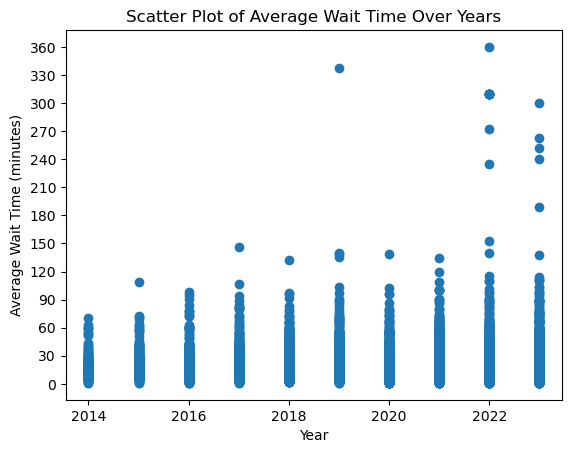

In [84]:
# Convert '-' to NaN and then drop rows with NaN in 'Average_Wait' and 'Average_Maximum_Wait'
ride_stats_df = ride_stats_df[pd.to_numeric(ride_stats_df['Average_Wait'], errors='coerce').notna()]
ride_stats_df = ride_stats_df[pd.to_numeric(ride_stats_df['Average_Maximum_Wait'], errors='coerce').notna()]

# Convert the columns to integers
ride_stats_df['Average_Wait'] = ride_stats_df['Average_Wait'].astype(int)
ride_stats_df['Average_Maximum_Wait'] = ride_stats_df['Average_Maximum_Wait'].astype(int)

plt.scatter(ride_stats_df['Year'], ride_stats_df['Average_Wait'])

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Average Wait Time (minutes)')
plt.title('Scatter Plot of Average Wait Time Over Years')

plt.yticks(range(0, max(ride_stats_df['Average_Wait']) + 1, 30))

# Display the plot
plt.show()

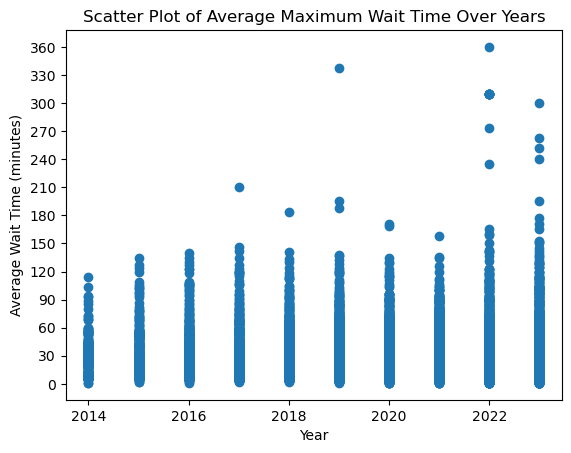

In [85]:
plt.scatter(ride_stats_df['Year'], ride_stats_df['Average_Maximum_Wait'])

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Average Wait Time (minutes)')
plt.title('Scatter Plot of Average Maximum Wait Time Over Years')

plt.yticks(range(0, max(ride_stats_df['Average_Wait']) + 1, 30))

# Display the plot
plt.show()

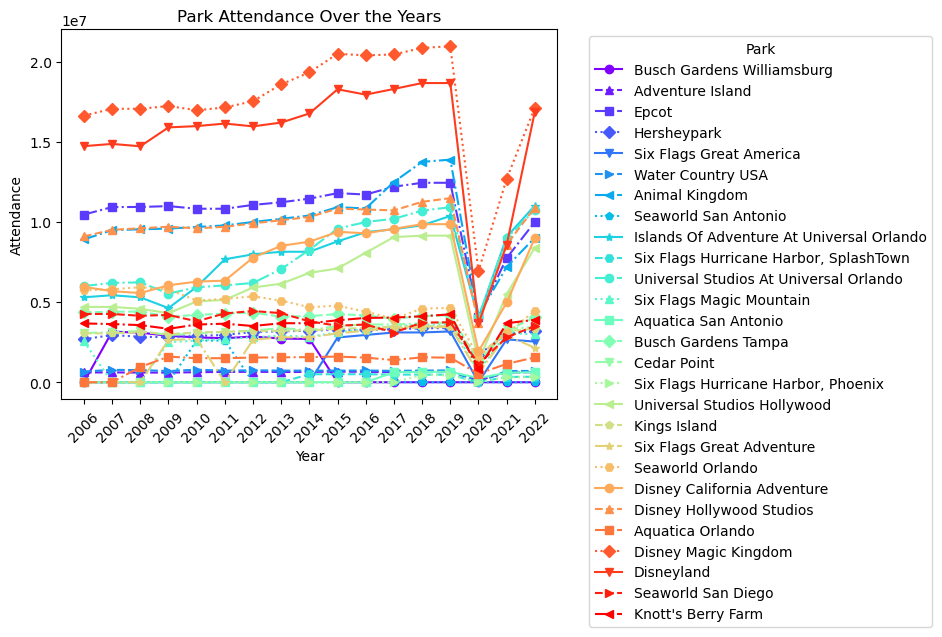

In [86]:
usa_parks_view_df = doSqlAccess(cursor, "SELECT * FROM parks WHERE country_code = 'us'", "", False)

# Calculate total attendance for each park
usa_parks_view_df['total_attendance'] = usa_parks_view_df[['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']].sum(axis=1)

# Filter parks with total attendance greater than 200,000
filtered_parks_df = usa_parks_view_df[usa_parks_view_df['total_attendance'] > 200000]

# Extract relevant columns for plotting
attendance_data = filtered_parks_df[['Park_Name', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']]

# Set 'Park_Name' as the index for easier plotting
attendance_data = attendance_data.set_index('Park_Name')

# Transpose the DataFrame for easy plotting
attendance_data = attendance_data.T

# Define a list of line styles, marker shapes, and colors
line_styles = ['-', '--', '-.', ':']  
marker_shapes = ['o', '^', 's', 'D', 'v', '>', '<', 'p', '*', 'H']  

# Generates a range of colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(attendance_data.columns))) 

# Plot the data for each park with different line styles, marker shapes, and colors
for i, park in enumerate(attendance_data.columns):
    plt.plot(attendance_data.index, attendance_data[park], linestyle=line_styles[i % len(line_styles)],
             marker=marker_shapes[i % len(marker_shapes)], color=colors[i], label=park)


# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.xlabel('Year')
plt.ylabel('Attendance')
plt.title('Park Attendance Over the Years')
plt.legend(title='Park', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


#### Clean up some fields before merge: 

In [87]:
# Step by Step Merge:

# Check for missing values in 'Ride_Number' column
print("Missing Ride Numbers in ride_stats_year_df:", ride_stats_df['Ride_Number'].isnull().sum())
print(ride_stats_df.columns)

print("Missing Ride Numbers in coasters_view_df:", coasters_view_df['Ride_Number'].isnull().sum())
print(coasters_view_df.columns)


Missing Ride Numbers in ride_stats_year_df: 0
Index(['Ride_Number', 'Park_Number', 'Year', 'Average_Wait',
       'Average_Maximum_Wait'],
      dtype='object')
Missing Ride Numbers in coasters_view_df: 1
Index(['Ride_Number', 'Ride_Name', 'Park_Number', 'Height', 'Speed', 'Drop',
       'wood', 'steel', 'launched', 'flying', 'Opening_Date', 'Manufacturer',
       'Opening_Year'],
      dtype='object')


In [88]:
# Verify merging condition
print("Unique Ride Numbers in ride_stats_year_df:", ride_stats_df['Ride_Number'].nunique())
print("Unique Ride Numbers in coasters_view_df:", coasters_view_df['Ride_Number'].nunique())

print(tabulate(ride_stats_df.head(10), headers=ride_stats_columns, tablefmt='psql', showindex=False))
print(tabulate(coasters_view_df.head(10), headers=coaster_columns, tablefmt='psql', showindex=False))


Unique Ride Numbers in ride_stats_year_df: 3619
Unique Ride Numbers in coasters_view_df: 359
+---------------+---------------+--------+----------------+------------------------+
|   Ride_Number |   Park_Number |   Year |   Average_Wait |   Average_Maximum_Wait |
|---------------+---------------+--------+----------------+------------------------|
|          8857 |           273 |   2022 |             11 |                     13 |
|          8857 |           273 |   2023 |              8 |                      8 |
|          3718 |            24 |   2015 |             22 |                     29 |
|          3718 |            24 |   2016 |             15 |                     22 |
|          3718 |            24 |   2017 |             12 |                     18 |
|          3718 |            24 |   2018 |              6 |                      7 |
|         11236 |            29 |   2023 |             21 |                     34 |
|          9315 |           304 |   2021 |              7

In [89]:
ride_stats_df['Ride_Number'] = ride_stats_df['Ride_Number'].astype(str)

coasters_view_df = coasters_view_df.dropna(subset=['Ride_Number'])

if START_FROM_LAST_MILESTONE:
    # This fixes an issue in the saved sql data. The ride number is saved as a float.
    coasters_view_df['Ride_Number'] = coasters_view_df['Ride_Number'].astype(float).astype(int).astype(str)
else:
    coasters_view_df['Ride_Number'] = coasters_view_df['Ride_Number'].astype(str)

# print("Unique Ride Numbers in coasters_view_df:", set(coasters_view_df['Ride_Number']))
# print("Unique Ride Numbers in ride_stats_df:", set(ride_stats_df['Ride_Number']))

ride_stats_df['Ride_Number'] = ride_stats_df['Ride_Number'].str.strip()
coasters_view_df['Ride_Number'] = coasters_view_df['Ride_Number'].str.strip()

# Display matching values
common_rides = set(ride_stats_df['Ride_Number']).intersection(set(coasters_view_df['Ride_Number']))
print("Common Ride Numbers:", len(common_rides))


Common Ride Numbers: 359


<span style="color:red; font-size:1.5em;">
    <b><u>Merge the Ride Stats Table with the Coasters Table.</u></b>
</span>

In [90]:
# I am going to do math with these, but they have text in some of the rows, specifically a few with "-"
# These could mean 'no wait' or 'no data'. I will just drop them for our graphs.
ride_stats_df['Average_Wait'] = pd.to_numeric(ride_stats_df['Average_Wait'], errors='coerce')
ride_stats_df['Average_Maximum_Wait'] = pd.to_numeric(ride_stats_df['Average_Maximum_Wait'], errors='coerce')

# Merge the dataframes on 'Ride_Number' and 'Park_Number'
merged_rides_df = pd.merge(ride_stats_df, coasters_view_df, on=['Ride_Number', 'Park_Number'], how='left', suffixes=('_ride_stats', '_coasters'))

# print(ride_stats_df.columns)
# print(coasters_view_df.columns)
# print(merged_rides_df.columns)

# Convert the 'Opening_Year' column to numeric (in case it's stored as a string)
merged_rides_df['Opening_Year'] = pd.to_numeric(merged_rides_df['Opening_Year'], errors='coerce')
merged_rides_df['Year'] = pd.to_numeric(merged_rides_df['Year'], errors='coerce')

# Calculate the age of the ride
merged_rides_df['Ride_Age'] = merged_rides_df['Year'] - merged_rides_df['Opening_Year']

# Drop rows where 'Ride_Age' is NaN (indicating no match in the merge)
merged_rides_df = merged_rides_df.dropna(subset=['Ride_Age'])

# Drop rows where 'Ride_Age' is less than zero.
merged_rides_df = merged_rides_df[merged_rides_df['Ride_Age'] >= 0]

# Drop unnecessary columns if needed
# merged_rides_df = merged_rides_df.drop(['Opening_Date', 'Opening_Year'], axis=1)
print(merged_rides_df.columns)

all_columns = ['Ride_Number', 'Park_Number', 'Year', 'Average_Wait', 'Average_Maximum_Wait', 'Ride_Name',
               'Height', 'Speed', 'Drop', 'wood', 'steel', 'launched', 'flying', 
               'Opening_Date', 'Manufacturer', 'Opening_Year', 'Ride_Age']


Index(['Ride_Number', 'Park_Number', 'Year', 'Average_Wait',
       'Average_Maximum_Wait', 'Ride_Name', 'Height', 'Speed', 'Drop', 'wood',
       'steel', 'launched', 'flying', 'Opening_Date', 'Manufacturer',
       'Opening_Year', 'Ride_Age'],
      dtype='object')


#### Merge Park Data Too 

2nd Merge on parks_view_df. Merge on 'Park_Number'. Add 'Park_Name' & 'Owner_Name' to merged_df.


In [91]:
# Merge with parks_view_df
final_merge_info_df = pd.merge(merged_rides_df, parks_view_df[['Park_Number', 'Park_Name', 'Owner_Name']], on='Park_Number', how='left')

print(final_merge_info_df.columns)

some_columns = ['Ride_Name', 'Owner_Name', 'Park_Number', 'Average_Wait', 'Ride_Age']
some_merged_df = final_merge_info_df[some_columns]

# Display the result
print(tabulate(some_merged_df.head(10), headers=some_columns, tablefmt='psql', showindex=False))



Index(['Ride_Number', 'Park_Number', 'Year', 'Average_Wait',
       'Average_Maximum_Wait', 'Ride_Name', 'Height', 'Speed', 'Drop', 'wood',
       'steel', 'launched', 'flying', 'Opening_Date', 'Manufacturer',
       'Opening_Year', 'Ride_Age', 'Park_Name', 'Owner_Name'],
      dtype='object')
+--------------------+-------------------------------------+---------------+----------------+------------+
| Ride_Name          | Owner_Name                          |   Park_Number |   Average_Wait |   Ride_Age |
|--------------------+-------------------------------------+---------------+----------------+------------|
| Lil' Devil Coaster | Six Flags Entertainment Corporation |            37 |              7 |          0 |
| Lil' Devil Coaster | Six Flags Entertainment Corporation |            37 |             15 |          1 |
| Lil' Devil Coaster | Six Flags Entertainment Corporation |            37 |             11 |          2 |
| Rattlesnake        | Merlin Entertainments               |   

#### Add Owner Name to Two Different Tables

Requires two merges but makes graphing easier.

In [92]:
print(coasters_view_df.columns)

Index(['Ride_Number', 'Ride_Name', 'Park_Number', 'Height', 'Speed', 'Drop',
       'wood', 'steel', 'launched', 'flying', 'Opening_Date', 'Manufacturer',
       'Opening_Year'],
      dtype='object')


#### In Place Merge of Owner Name

I merge directly into coasters_view_df. If this is executed twice (sometimes I do), you have to deal with suffixes. Therefore, I drop the column from coasters_view_df first.

In [93]:

# Drop the 'Owner_Name' column from coasters_view_df
if 'Owner_Name' in coasters_view_df.columns:
    coasters_view_df = coasters_view_df.drop('Owner_Name', axis=1)

# Merge with parks_view_df to get Owner_Name (in place)
coasters_view_df = pd.merge(coasters_view_df, parks_view_df[['Park_Number', 'Owner_Name']], on='Park_Number', how='left')

# # Drop the '_coasters' suffixed column
# coasters_view_df = coasters_view_df.drop('Owner_Name_coasters', axis=1)

# # Rename the '_parks' suffixed column to 'Owner_Name'
# coasters_view_df = coasters_view_df.rename(columns={'Owner_Name_parks': 'Owner_Name'})


In [94]:
print(coasters_view_df.columns)

Index(['Ride_Number', 'Ride_Name', 'Park_Number', 'Height', 'Speed', 'Drop',
       'wood', 'steel', 'launched', 'flying', 'Opening_Date', 'Manufacturer',
       'Opening_Year', 'Owner_Name'],
      dtype='object')


#### Allow Grouping by Owner and Manufacturer

##### Bonus Transformation.

There are too many for graphing.

In [95]:
print("Unique owners in final_merge_info_df:", set(final_merge_info_df['Owner_Name']))


Unique owners in final_merge_info_df: {'Cedar Fair Entertainment Company', 'Plopsa', 'Parques Reunidos', 'Walt Disney Attractions', 'Universal Parks & Resorts', 'SeaWorld Parks & Entertainment', 'Compagnie des Alpes', 'Mack Rides', 'Merlin Entertainments', 'Six Flags Entertainment Corporation', 'PortAventura World', 'Other', 'Herschend Family Entertainment'}


In [96]:
print("Unique Manufacturers in coasters_view_df:", set(coasters_view_df['Manufacturer']))


Unique Manufacturers in coasters_view_df: {'Charlie Mach', 'Philadelphia Toboggan Coasters', 'Bolliger & Mabillard', 'Six Flags', 'Vekoma', 'Chance Manufacturing', 'William Cobb & Associates', 'Chance Morgan', 'Mack Rides GmbH & Co KG', 'Rauenhorst Corporation', 'Zierer', 'Arrow Development (1977–2003)Dynamic Structures (2005–present)]]', "Canada's Wonderland", 'Premier Rides', 'Gerstlauer', 'Great Coasters International', 'Taft Broadcasting Company', 'Kumbak', 'Taft Broadcasting', 'Roller Coaster Corporation of America', 'Anton Schwarzkopf', 'Arrow Dynamics', 'D. H. Morgan Manufacturing', 'Zamperla', 'E&F Miler Industries', 'Arrow Development', 'Knoebels Amusement Resort', 'Harry C. Baker', 'S&S - Sansei Technologies', 'Art Engineering', None, 'Joseph E. Drambour', 'S&S – Sansei Technologies', 'Reverchon Industries', 'Giovanola', 'Herschend Family Entertainment', 'Rocky Mountain Construction', 'Maurer AG', 'Mack Rides', 'Intamin', 'William Strickler', 'Kings Island', 'Dinn Corporation

In [97]:
def group_owners_by_condition(df, condition_column='Owner_Name'):
    owner_name_conditions = [
        df[condition_column] == 'Universal Parks & Resorts',
        df[condition_column] == 'Walt Disney Attractions',
        df[condition_column] == 'Six Flags Entertainment Corporation',
        df[condition_column] == 'Herschend Family Entertainment',
        df[condition_column] == 'Cedar Fair Entertainment Company',
        df[condition_column] == 'SeaWorld Parks & Entertainment',
        df[condition_column] == 'Merlin Entertainments'
    ]

    # Define the corresponding grouped values
    grouped_owners = [
        'Universal Parks & Resorts',
        'Walt Disney Attractions',
        'Six Flags Entertainment Corporation',
        'Herschend Family Entertainment',
        'Cedar Fair Entertainment Company',
        'SeaWorld Parks & Entertainment',
        'Merlin Entertainments'
    ]

    # Create a new column 'Grouped_Owners' based on the conditions
    df['Grouped_Owners'] = np.select(owner_name_conditions, grouped_owners, default='Other')

# With the Six Flags-Cedar Fair merge
def post_merge_owners_by_condition(df, condition_column='Owner_Name'):
    post_merge_name_conditions = [
        df[condition_column] == 'Universal Parks & Resorts',
        df[condition_column] == 'Walt Disney Attractions',
        (df[condition_column] == 'Six Flags Entertainment Corporation') | (df[condition_column] == 'Cedar Fair Entertainment Company'),
        df[condition_column] == 'Herschend Family Entertainment',
        df[condition_column] == 'SeaWorld Parks & Entertainment',
        df[condition_column] == 'Merlin Entertainments'
    ]

    # Define the corresponding grouped values
    post_merge_owners = [
        'Universal Parks & Resorts',
        'Walt Disney Attractions',
        'Six Flags/Cedar Fair',
        'Herschend Family Entertainment',
        'SeaWorld Parks & Entertainment',
        'Merlin Entertainments'
    ]

    # Create a new column 'Post_Merge_Owners' based on the conditions
    df['Post_Merge_Owners'] = np.select(post_merge_name_conditions, post_merge_owners, default='Other')
    
def manufacturers_by_condition(df, condition_column='Owner_Name'):
    manufacturer_conditions = [
        df['Manufacturer'] == 'Rocky Mountain Construction',
        df['Manufacturer'] == 'Great Coasters International',
        df['Manufacturer'] == 'Intamin',
        (df['Manufacturer'] == 'Mack Rides') | (df['Manufacturer'] == 'Mack Rides GmbH & Co KG'),
        df['Manufacturer'] == 'Bolliger & Mabillard',
        df['Manufacturer'] == 'Vekoma',
        df['Manufacturer'] == 'Premier Rides'
    ]

    grouped_manufacturers = [
        'Rocky Mountain Construction',
        'Great Coasters International',
        'Intamin',
        'Mack Rides',
        'Bolliger & Mabillard',
        'Vekoma',
        'Premier Rides'
    ]

    # Create a new column 'Grouped_Owners' based on the conditions
    df['Grouped_Manufacturers'] = np.select(manufacturer_conditions, grouped_manufacturers, default='Other')

# Apply the function to the dataframes
group_owners_by_condition(final_merge_info_df)
group_owners_by_condition(coasters_view_df)

post_merge_owners_by_condition(final_merge_info_df)
post_merge_owners_by_condition(coasters_view_df)

manufacturers_by_condition(coasters_view_df)
manufacturers_by_condition(final_merge_info_df)



#### Ready for Some Wild and Fun Graphs!

#### Color Coding for Owners and Manufacturers.

In [98]:
# Get colors based on grouped owners
owner_colors = {
    'Universal Parks & Resorts': 'orange',
    'Walt Disney Attractions': 'green',
    'Six Flags Entertainment Corporation': 'cyan',
    'Herschend Family Entertainment': 'purple',
    'Cedar Fair Entertainment Company': 'red',
    'SeaWorld Parks & Entertainment': 'blue',
    'Merlin Entertainments': 'yellow',
    'Other': 'gray'
}

# Post Six Flags/Cedar Fair merge colors
post_merge_colors = {
    'Universal Parks & Resorts': 'orange',
    'Walt Disney Attractions': 'green',
    'Six Flags/Cedar Fair': 'red',
    'Herschend Family Entertainment': 'purple',
    'SeaWorld Parks & Entertainment': 'blue',
    'Merlin Entertainments': 'yellow',
    'Other': 'gray'
}

# Get colors based on grouped manufacturers
manufacturer_colors = {
    'Rocky Mountain Construction': 'orange',
    'Great Coasters International': 'green',
    'Intamin': 'blue',
    'Mack Rides': 'purple',
    'Bolliger & Mabillard': 'red',
    'Vekoma': 'cyan',
    'Premier Rides': 'yellow',
    'Other': 'gray'
}

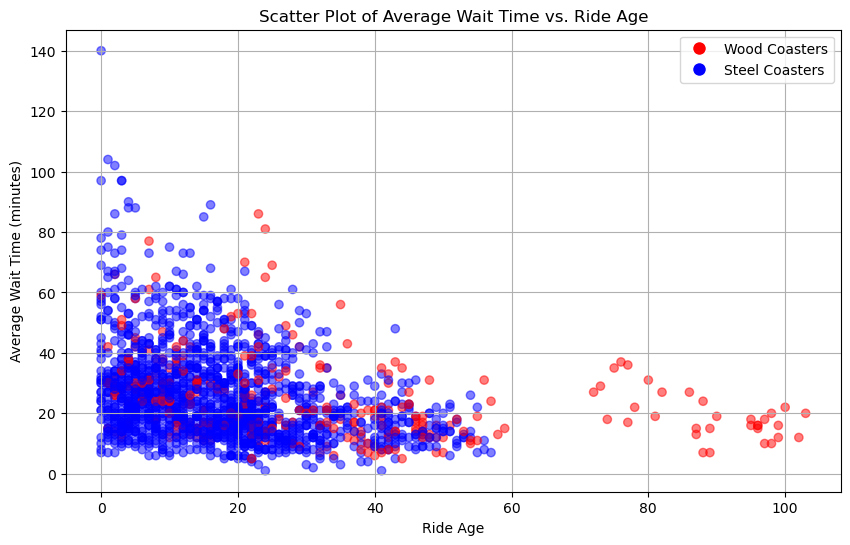

In [99]:
wood_coasters = final_merge_info_df['wood']

# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(final_merge_info_df['Ride_Age'], final_merge_info_df['Average_Wait'], alpha=0.5, c=['red' if wood else 'blue' for wood in wood_coasters])
plt.title('Scatter Plot of Average Wait Time vs. Ride Age')
plt.xlabel('Ride Age')
plt.ylabel('Average Wait Time (minutes)')
plt.grid(True)

# Add a legend for wood/steel
legend1 = plt.Line2D([0], [0], marker='o', color='w', label='Wood Coasters', markerfacecolor='red', markersize=10)
legend2 = plt.Line2D([0], [0], marker='o', color='w', label='Steel Coasters', markerfacecolor='blue', markersize=10)
plt.legend(handles=[legend1, legend2])


plt.show()

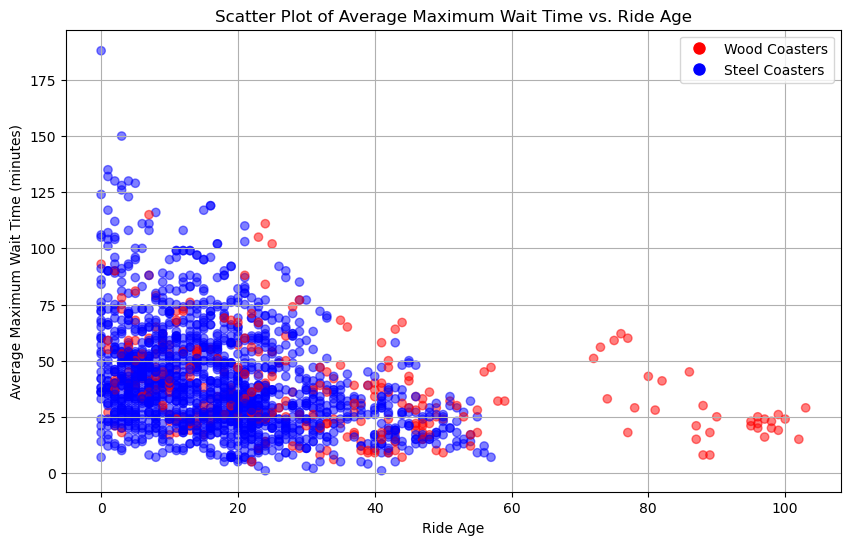

In [100]:
wood_coasters = final_merge_info_df['wood']

# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(final_merge_info_df['Ride_Age'], final_merge_info_df['Average_Maximum_Wait'], alpha=0.5, c=['red' if wood else 'blue' for wood in wood_coasters])
plt.title('Scatter Plot of Average Maximum Wait Time vs. Ride Age')
plt.xlabel('Ride Age')
plt.ylabel('Average Maximum Wait Time (minutes)')
plt.grid(True)

# Add a legend for wood/steel
legend1 = plt.Line2D([0], [0], marker='o', color='w', label='Wood Coasters', markerfacecolor='red', markersize=10)
legend2 = plt.Line2D([0], [0], marker='o', color='w', label='Steel Coasters', markerfacecolor='blue', markersize=10)
plt.legend(handles=[legend1, legend2])


plt.show()

#### Ride Manufacturers vs Age of Coasters

Index(['Ride_Number', 'Park_Number', 'Year', 'Average_Wait',
       'Average_Maximum_Wait', 'Ride_Name', 'Height', 'Speed', 'Drop', 'wood',
       'steel', 'launched', 'flying', 'Opening_Date', 'Manufacturer',
       'Opening_Year', 'Ride_Age', 'Park_Name', 'Owner_Name', 'Grouped_Owners',
       'Post_Merge_Owners', 'Grouped_Manufacturers'],
      dtype='object')


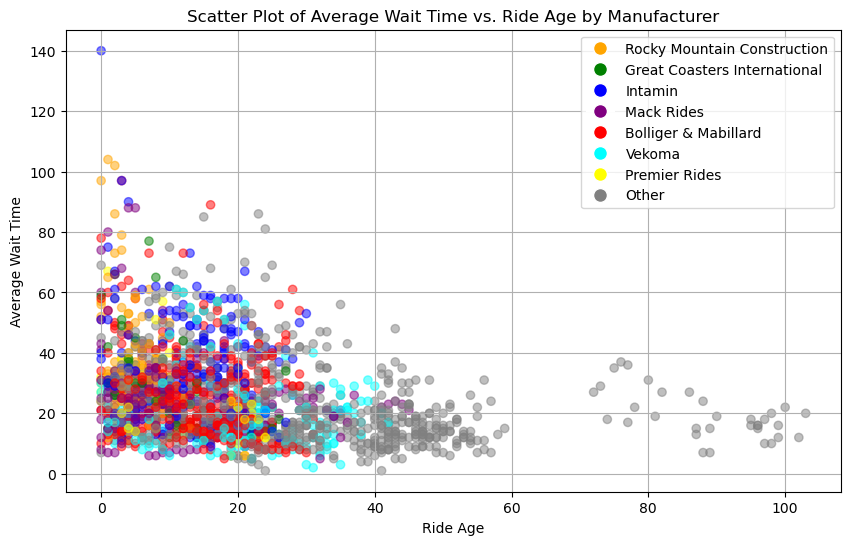

In [101]:
print(final_merge_info_df.columns)


# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_merge_info_df['Ride_Age'],
    final_merge_info_df['Average_Wait'],
    alpha=0.5,
    c=[manufacturer_colors[manufacturer] for manufacturer in final_merge_info_df['Grouped_Manufacturers']]
)
plt.title('Scatter Plot of Average Wait Time vs. Ride Age by Manufacturer')
plt.xlabel('Ride Age')
plt.ylabel('Average Wait Time')
plt.grid(True)

# Add a legend for grouped manufacturers
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=manufacturer, markerfacecolor=color, markersize=10) for manufacturer, color in manufacturer_colors.items()]
plt.legend(handles=legend_handles)

plt.show()

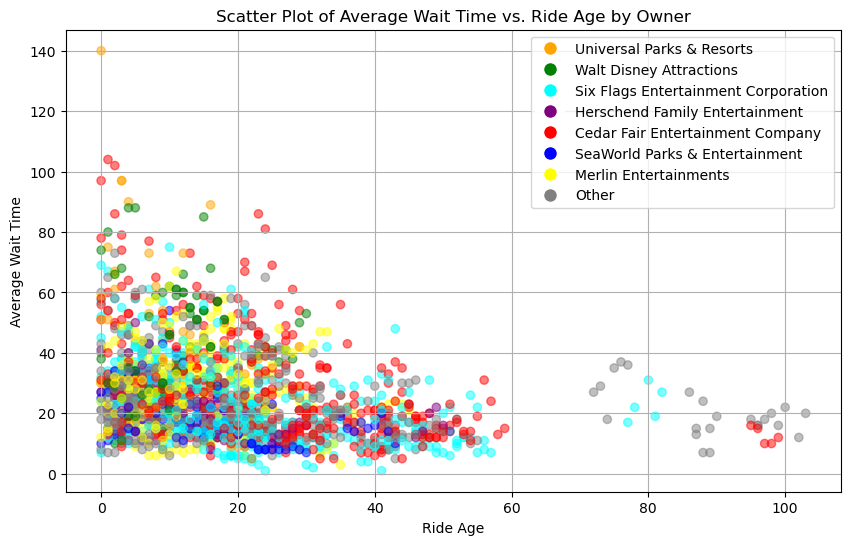

In [102]:
# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_merge_info_df['Ride_Age'],
    final_merge_info_df['Average_Wait'],
    alpha=0.5,
    c=[owner_colors[owner] for owner in final_merge_info_df['Grouped_Owners']]
)
plt.title('Scatter Plot of Average Wait Time vs. Ride Age by Owner')
plt.xlabel('Ride Age')
plt.ylabel('Average Wait Time')
plt.grid(True)

# Add a legend for grouped owners
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=owner, markerfacecolor=color, markersize=10) for owner, color in owner_colors.items()]
plt.legend(handles=legend_handles)

plt.show()

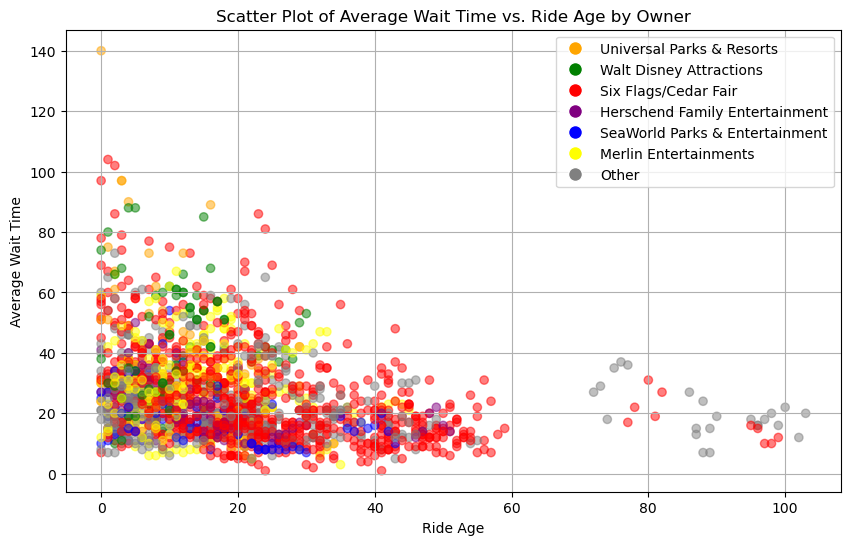

In [103]:
# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_merge_info_df['Ride_Age'],
    final_merge_info_df['Average_Wait'],
    alpha=0.5,
    c=[post_merge_colors[owner] for owner in final_merge_info_df['Post_Merge_Owners']]
)
plt.title('Scatter Plot of Average Wait Time vs. Ride Age by Owner')
plt.xlabel('Ride Age')
plt.ylabel('Average Wait Time')
plt.grid(True)

# Add a legend for grouped owners
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=owner, markerfacecolor=color, markersize=10) for owner, color in post_merge_colors.items()]
plt.legend(handles=legend_handles)

plt.show()

#### Other Attributes (Height/Speed/Drop etc)

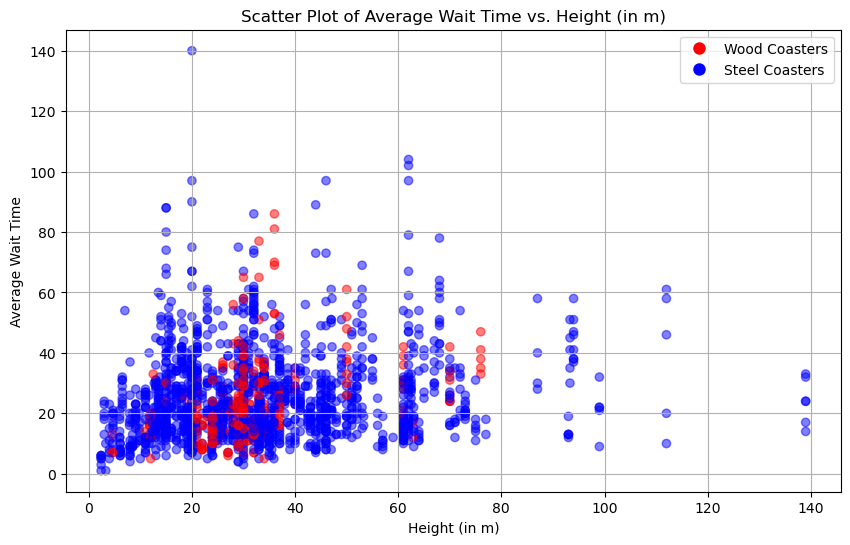

In [104]:
wood_coasters = final_merge_info_df['wood']

# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(final_merge_info_df['Height'], final_merge_info_df['Average_Wait'], alpha=0.5, c=['red' if wood else 'blue' for wood in wood_coasters])
plt.title('Scatter Plot of Average Wait Time vs. Height (in m)')
plt.xlabel('Height (in m)')
plt.ylabel('Average Wait Time')
plt.grid(True)

# Add a legend for wood/steel
legend1 = plt.Line2D([0], [0], marker='o', color='w', label='Wood Coasters', markerfacecolor='red', markersize=10)
legend2 = plt.Line2D([0], [0], marker='o', color='w', label='Steel Coasters', markerfacecolor='blue', markersize=10)
plt.legend(handles=[legend1, legend2])


plt.show()

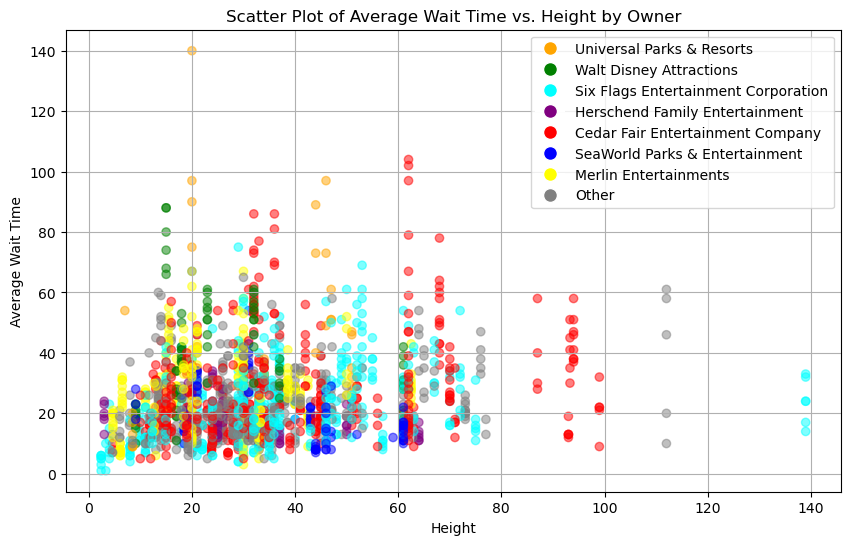

In [105]:
# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_merge_info_df['Height'],
    final_merge_info_df['Average_Wait'],
    alpha=0.5,
    c=[owner_colors[owner] for owner in final_merge_info_df['Grouped_Owners']]
)
plt.title('Scatter Plot of Average Wait Time vs. Height by Owner')
plt.xlabel('Height')
plt.ylabel('Average Wait Time')
plt.grid(True)

# Add a legend for grouped owners
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=owner, markerfacecolor=color, markersize=10) for owner, color in owner_colors.items()]
plt.legend(handles=legend_handles)

plt.show()

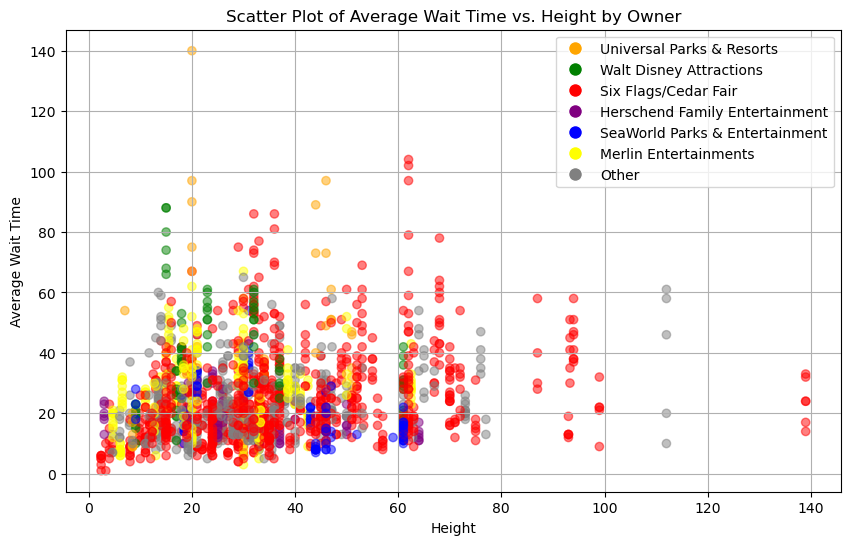

In [106]:
# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_merge_info_df['Height'],
    final_merge_info_df['Average_Wait'],
    alpha=0.5,
    c=[post_merge_colors[owner] for owner in final_merge_info_df['Post_Merge_Owners']]
)
plt.title('Scatter Plot of Average Wait Time vs. Height by Owner')
plt.xlabel('Height')
plt.ylabel('Average Wait Time')
plt.grid(True)

# Add a legend for grouped owners
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=owner, markerfacecolor=color, markersize=10) for owner, color in post_merge_colors.items()]
plt.legend(handles=legend_handles)

plt.show()

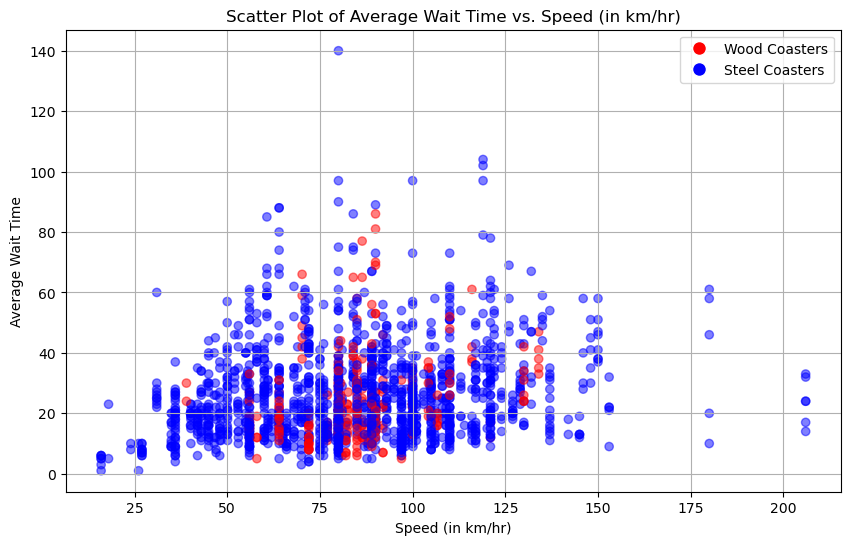

In [107]:
wood_coasters = final_merge_info_df['wood']

# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(final_merge_info_df['Speed'], final_merge_info_df['Average_Wait'], alpha=0.5, c=['red' if wood else 'blue' for wood in wood_coasters])
plt.title('Scatter Plot of Average Wait Time vs. Speed (in km/hr)')
plt.xlabel('Speed (in km/hr)')
plt.ylabel('Average Wait Time')
plt.grid(True)

# Add a legend for wood/steel
legend1 = plt.Line2D([0], [0], marker='o', color='w', label='Wood Coasters', markerfacecolor='red', markersize=10)
legend2 = plt.Line2D([0], [0], marker='o', color='w', label='Steel Coasters', markerfacecolor='blue', markersize=10)
plt.legend(handles=[legend1, legend2])


plt.show()

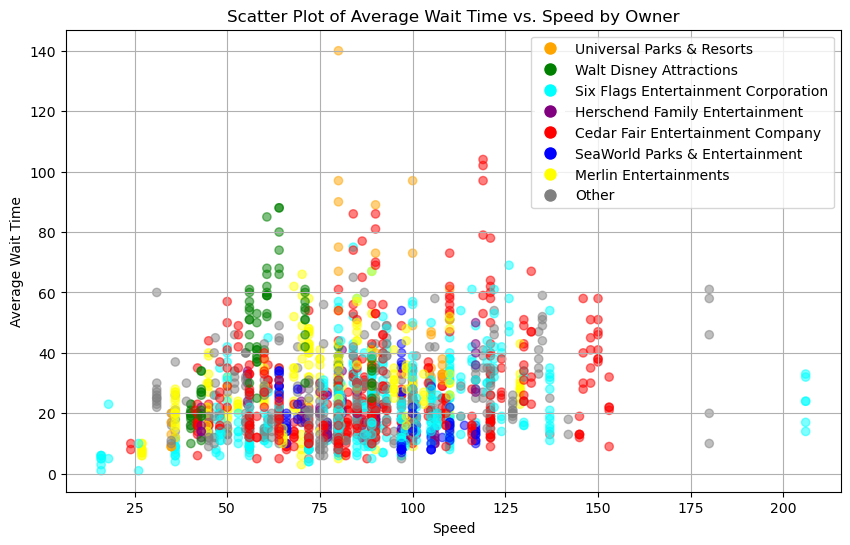

In [108]:
# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_merge_info_df['Speed'],
    final_merge_info_df['Average_Wait'],
    alpha=0.5,
    c=[owner_colors[owner] for owner in final_merge_info_df['Grouped_Owners']]
)
plt.title('Scatter Plot of Average Wait Time vs. Speed by Owner')
plt.xlabel('Speed')
plt.ylabel('Average Wait Time')
plt.grid(True)

# Add a legend for grouped owners
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=owner, markerfacecolor=color, markersize=10) for owner, color in owner_colors.items()]
plt.legend(handles=legend_handles)

plt.show()

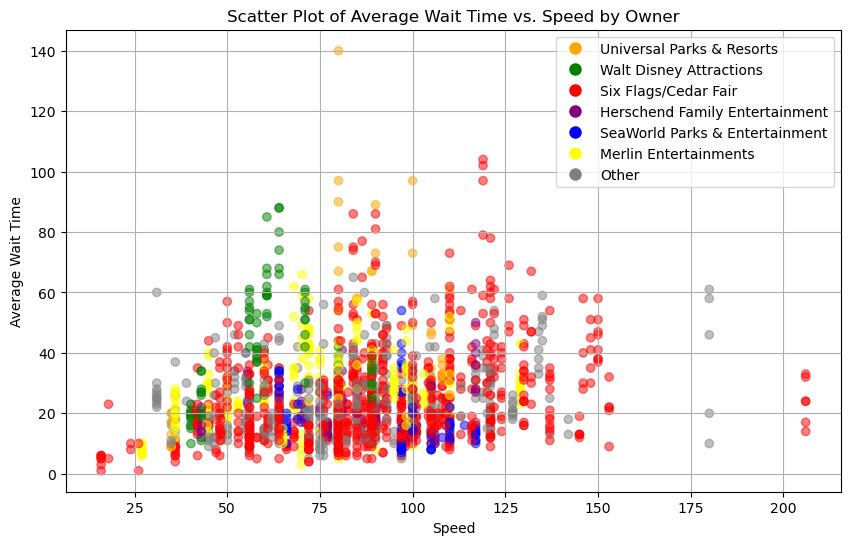

In [109]:
# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_merge_info_df['Speed'],
    final_merge_info_df['Average_Wait'],
    alpha=0.5,
    c=[post_merge_colors[owner] for owner in final_merge_info_df['Post_Merge_Owners']]
)
plt.title('Scatter Plot of Average Wait Time vs. Speed by Owner')
plt.xlabel('Speed')
plt.ylabel('Average Wait Time')
plt.grid(True)

# Add a legend for grouped owners
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=owner, markerfacecolor=color, markersize=10) for owner, color in post_merge_colors.items()]
plt.legend(handles=legend_handles)

plt.show()

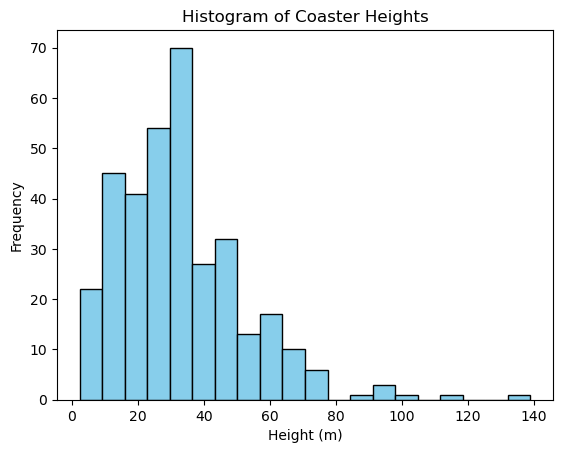

In [110]:
# Plot histogram of coaster heights
plt.hist(coasters_view_df['Height'], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Coaster Heights')
plt.xlabel('Height (m)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

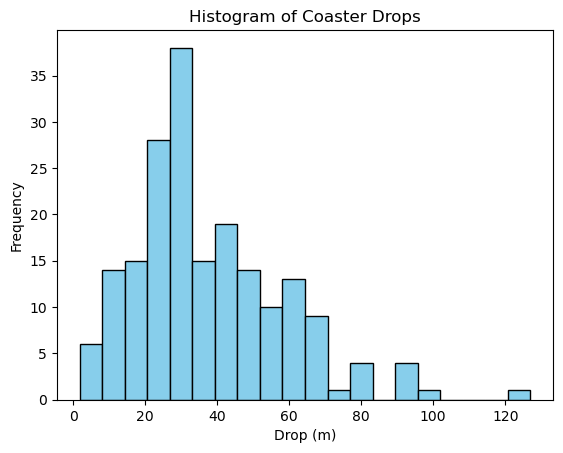

In [111]:
# Plot histogram of coaster heights
plt.hist(coasters_view_df['Drop'], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Coaster Drops')
plt.xlabel('Drop (m)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

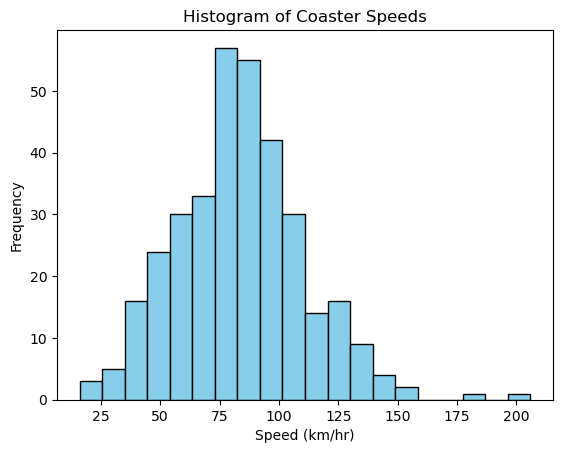

In [112]:
# Plot histogram of coaster speedss
plt.hist(coasters_view_df['Speed'], bins=20, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Coaster Speeds')
plt.xlabel('Speed (km/hr)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

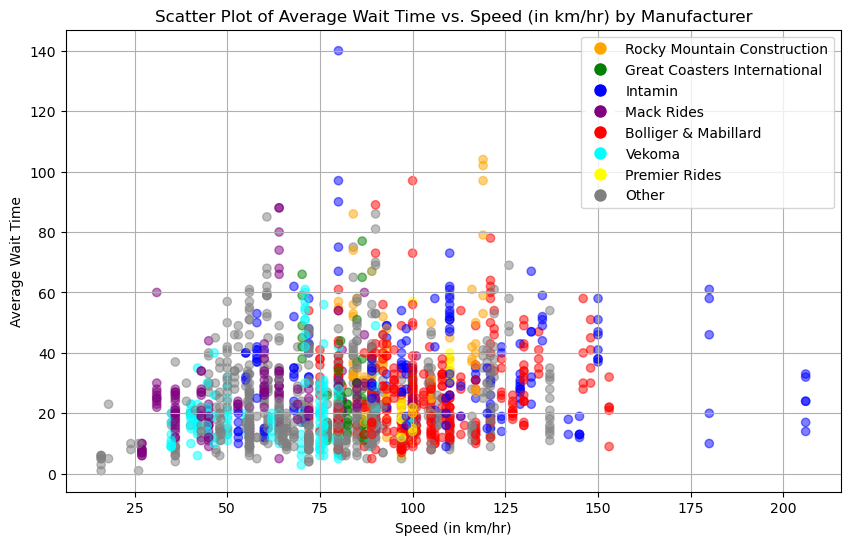

In [113]:

# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_merge_info_df['Speed'],
    final_merge_info_df['Average_Wait'],
    alpha=0.5,
    c=[manufacturer_colors[manufacturer] for manufacturer in final_merge_info_df['Grouped_Manufacturers']]
)
plt.title('Scatter Plot of Average Wait Time vs. Speed (in km/hr) by Manufacturer')
plt.xlabel('Speed (in km/hr)')
plt.ylabel('Average Wait Time')
plt.grid(True)

# Add a legend for grouped manufacturers
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=manufacturer, markerfacecolor=color, markersize=10) for manufacturer, color in manufacturer_colors.items()]
plt.legend(handles=legend_handles)

plt.show()

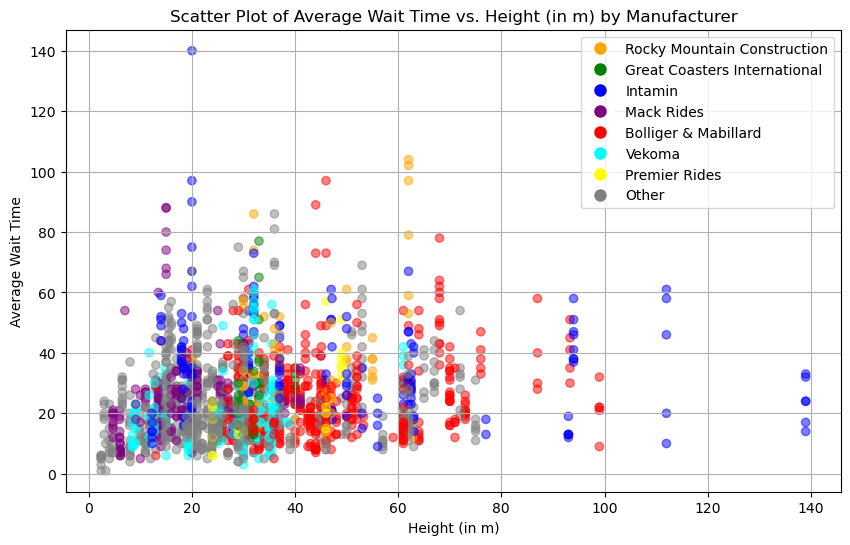

In [114]:

# Plotting the scatter plot with conditional coloring
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    final_merge_info_df['Height'],
    final_merge_info_df['Average_Wait'],
    alpha=0.5,
    c=[manufacturer_colors[manufacturer] for manufacturer in final_merge_info_df['Grouped_Manufacturers']]
)
plt.title('Scatter Plot of Average Wait Time vs. Height (in m) by Manufacturer')
plt.xlabel('Height (in m)')
plt.ylabel('Average Wait Time')
plt.grid(True)

# Add a legend for grouped manufacturers
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=manufacturer, markerfacecolor=color, markersize=10) for manufacturer, color in manufacturer_colors.items()]
plt.legend(handles=legend_handles)

plt.show()